In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt, resample
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder, StandardScaler
import time
import random

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, BatchNormalization
from keras.layers.core import Permute, Reshape
from keras import backend as K

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 1: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)


## Helper fcns

In [3]:
def LOSOCV(Data,X,y,groups,models):

    subj = LeaveOneGroupOut() 

    #train multiple classifiers
    for m in models:
        Sens_all=[]; Spec_all=[]; 
        acc_all=[]; acc_train=[] #sens and spec for current model and all subject
        f1_test_all=[]; prec_all=[]; rec_all=[]; auprc_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            
            #f1-score, prec and recall, auprc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            
            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            print('\nSubj %d, prec=%.3f, rec=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred)))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all)))
        
          


#             #compute Sens and Spec for current subject and classifier
#             if np.sum(yte==1)>0:                    
#                 Sens = sum((ypred==1)&( yte==1))/sum(yte==1)
#             else:
#                 print('%s has no positive examples'%Data.Subject[test_index].unique())
#                 Sens = np.nan
#             if np.sum(yte==0)>0:
#                 Spec = sum((ypred==0) & (yte==0))/sum(yte==0)
#             else:
#                 Spec = np.nan
#                 print('%s has no negative examples'%Data.Subject[test_index].unique())
#             Sens_all.append(Sens); Spec_all.append(Spec)
#             #compute accuracy
#             acc = sum(ypred==yte)/len(yte)
#             acc_all.append(acc)
        
        #mean across all subjects
#         print(('%s, mean Acc on training set = %.3f (+/- %0.3f)')%(model_name,np.nanmean(acc_train),2*np.nanstd(acc_train)/np.sqrt(len(acc_train))))
#         print(('%s, mean Sens = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Sens_all),2*np.nanstd(Sens_all)/np.sqrt(len(Sens_all))))
#         print(('%s, mean Spec = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Spec_all),2*np.nanstd(Spec_all)/np.sqrt(len(Spec_all))))
#         print(('%s, mean Acc = %.3f (+/- %0.3f)')%(model_name,np.nanmean(acc_all),2*np.nanstd(acc_all)/np.sqrt(len(acc_all))))
        
       
    

#train multiple classifiers using stratified kfold
def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

    scaler = StandardScaler()
    f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

    skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
    for clf,model_name in models:
        f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

        for train_idx,test_idx in skf.split(Xf,y):
            Xtr = Xf[train_idx]
            ytr = y[train_idx]
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
#             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
            Xte = Xf[test_idx]
            yte = y[test_idx]
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
            clf.fit(Xtr,ytr)
            ypred_train = clf.predict(Xtr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train and test set for current fold
            precision, recall, _ = precision_recall_curve(yte,yscore)
            
            f1_train_fold.append(f1_score(ytr,ypred_train))
            f1_fold.append(f1_score(yte,ypred))
            prec_fold.append(precision_score(yte,ypred))
            rec_fold.append(recall_score(yte,ypred))
            auprc_fold.append(auc(recall,precision)
)


        #mean accuracy across folds
        if balance:
            print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
        print('%s'%model_name)
        print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
        np.nanmean(f1_fold),np.nanstd(f1_fold),
        np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
        np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
        cf_matrix = confusion_matrix(yte, ypred)
        print(cf_matrix)
        #store f1 and auc for each fold and clf
        f1_fold_clf.append(f1_fold)
        auc_fold_clf.append(auprc_fold)
        #store cmat for each clf (on last fold)
        cmats.update({model_name:cf_matrix})
        
    return f1_fold_clf, auc_fold_clf, cmats

    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [4]:
#---------------------------------------------------------------------------------------------------------
# Set path to folder containing Subject ID numbers
path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
# path = r'W:\CIS-PD Study\Subjects' #Windows local path adai
#---------------------------------------------------------------------------------------------------------
#Path where dictionary subject data is stored
# dict_path = 'W:\CIS-PD Study\Data_dict' #remote repo
dict_path = '../Data_dict' #local path
# dict_path = r'C:\Users\adai\Documents\Data_dict' #Windows local path adai

# scores_path = r'W:\CIS-PD Study\Scores' #remote repo
scores_path = '../Scores/' #local path

#path where feature matrix is saved
features_path = '../FeatureMatrix' #local

### CNN functions

In [5]:
# useful functions
def _data_reshaping(X_train, X_valid, network_type):
    _, win_len, dim = X_train.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':

        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_train = np.swapaxes(X_train,1,2)
        X_valid = np.swapaxes(X_valid,1,2)

        X_train = np.reshape(X_train, (-1, dim, win_len, 1))
        X_valid = np.reshape(X_valid, (-1, dim, win_len, 1))
    if network_type=='MLP':
        X_train = np.reshape(X_train, (-1, dim*win_len))
        X_valid = np.reshape(X_valid, (-1, dim*win_len))

    return X_train, X_valid


def model_conv(model):
    model.add(Conv2D(feat_map_num, kernel_size=(1, 5),
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(feat_map_num, kernel_size=(1, 5), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))


def model_eval(X_valid,y_valid):
    fig=plt.figure()
    fig.add_subplot(121)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('loss')
    fig.add_subplot(122)
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('accuracy')
    plt.legend(['train','test'],loc='best')

    #performance eval
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    y_true = np.argmax(y_valid, axis=1)
    y_score = model.predict(X_valid)[:,1]
    
    f1_test=f1_score(y_true,y_pred)
    Prec = precision_score(y_true,y_pred)
    Rec = recall_score(y_true,y_pred)
    Spec = sum((y_pred==0) & (y_true==0))/sum(y_true==0)

    precision, recall, _ = precision_recall_curve(y_true,y_score)
    auprc = auc(recall,precision)
    auroc = roc_auc_score(y_true,y_score)

    print('f1_test=%.3f, Prec=%.3f, Rec=%.3f, Spec=%.3f, auprc=%.3f, auroc=%.3f'%(f1_test,Prec,Rec,Spec,auprc,auroc))
    cf_matrix = confusion_matrix(y_true, y_pred)
    print(cf_matrix)
    class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
#     print('the mean f1 score:{:.2f}'.format(np.mean(class_wise_f1)))

    #compute ROC at fixed fpr (to plot error bars)
    fpr=np.linspace(0,1,101); tpr=[]
    nscores = np.sort(np.column_stack((y_score[y_true==0],y_true[y_true==0])),axis=0)
    neg_counts = sum(y_true==0)
    for f in fpr:
        ind = neg_counts-int(neg_counts*f)-1
        t = (nscores[ind])[0]
        if f==1:
            t = 0
        tpr_t = sum(y_score[y_true==1]>t) / sum(y_true==1)
        tpr.append(tpr_t) 

    fpr = np.asarray(fpr); tpr = np.asarray(tpr)

    return f1_test,Rec,Spec,auprc,auroc,fpr,tpr


def stdclipdata(X,plotdata=False):
    #standardize clips data by channel (for CNN)
    Xn = X.copy()
    acc = np.reshape(X,(X.shape[0]*X.shape[1],X.shape[2]))
    m = np.mean(acc,axis=0)
    s = np.std(acc,axis=0)
    for c in range(X.shape[0]):
        for a in range(X.shape[2]):
            Xn[c,:,a]=(X[c,:,a]-m[a])/s[a]
    Xn.shape
    if plotdata:
        for i in range(5,10):
            print(np.std(Xn[i],axis=0),np.std(X[i],axis=0))
            plt.plot(Xn[i])

    return Xn

def buildCNN(win_len,dim):
    num_classes = 2  

    model=Sequential()
    model.add(Conv2D(filters=16, kernel_size=(1, 32),activation='relu',input_shape=(1, win_len, dim),padding='same'))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 4)))
    model.add(Conv2D(filters=16, kernel_size=(1, 16), activation='relu',padding='same'))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 6)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
#     model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
#     model.add(BatchNormalization()) 
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
#     model.summary()
        
    return model

def buildCNN_reg(win_len,dim):

    model=Sequential()
    model.add(Conv2D(filters=16, kernel_size=(1, 32),activation='relu',input_shape=(1, win_len, dim),padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 4)))
    model.add(Conv2D(filters=16, kernel_size=(1, 16), activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 6)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='normal'))
        
    return model

### Load data

## CNN on rawdata

In [6]:
# data = pd.read_hdf('./FeatureMatrix/DataRawClipsUnfiltered.hdf5')
# data = pd.read_hdf('./FeatureMatrix/DataRawClips.hdf5') #HP Filtered Accelerometer
data = pd.read_hdf('./FeatureMatrix/DataRawFullDataset.hdf5') #unfiltered - Dataset w all subjects

In [7]:
data.head(3)

Subject            Visit               Task          Location  \
0     1004  2 Weeks: Time 0  Motor #2: Walking  dorsal_hand_left   
1     1004  2 Weeks: Time 0  Motor #2: Walking  dorsal_hand_left   
2     1004  2 Weeks: Time 0  Motor #2: Walking  dorsal_hand_left   

   Bradykinesia  Tremor  Dyskinesia  \
0           1.0     0.0         0.0   
1           1.0     0.0         0.0   
2           1.0     0.0         0.0   

                                             acc_xyz  \
0  [[0.38654154268711416, -0.98970016021973, 0.21...   
1  [[-0.03558403906309593, -1.087968261234455, 0....   
2  [[0.23297474631876106, -0.8850843060959792, 0....   

                                             gyr_xyz  
0  [[2.410925459678083, 28.71747920958251, 1.8005...  
1  [[-54.41367208361953, 12.970168612191856, 110....  
2  [[-45.25825894560171, 7.660028992141633, 38.78...

In [8]:
len(data)

35229

In [9]:
data.Visit.unique()

array(['2 Weeks: Time 0', '2 Weeks: Time 30', '2 Weeks: Time 60',
       '2 Weeks: Time 90', '2 Weeks: Time 120', '2 Weeks: Time 150',
       '4 Weeks'], dtype=object)

In [10]:
len(data.Subject.unique())

20

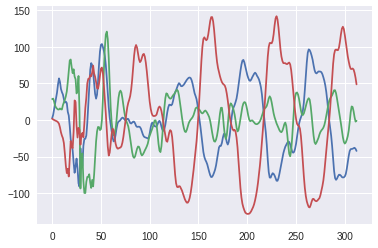

In [11]:
ax=plt.plot(data.gyr_xyz.values[0])

In [12]:
data.columns[7:]

Index(['acc_xyz', 'gyr_xyz'], dtype='object')

In [13]:
data[data.Dyskinesia >0].Task.unique()

array(['Motor #2: Walking', 'Motor #3: Walking while Counting',
       'Motor #5: Alternating Hand Movements', 'Motor #9: Nuts and Bolts',
       'Motor #4: Finger to Nose', 'Motor #6: Sit to Stand',
       'Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer',
       'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
       'Motor #12: Folding Towels'], dtype=object)

In [14]:
# data[data.Visit=='1 Month'].Subject
# data.loc[(data.Subject==1004)&(data.Visit=='1 Month')]
# data.loc[(data.Subject==1004)&(data.Visit=='4 Weeks')]

In [15]:
#get rid of subj 1020 and of 1M of data in subj 1004
data = data.loc[data.Subject!=1020]
data = data.loc[data.Visit!='1 Month']

In [17]:
#remove data from visit 7 (day 2, 4 weeks)
data = data.loc[data.Visit!='4 Weeks']

In [16]:
#unpack clips, scores, subj and task data
le = LabelEncoder()
acc = data.acc_xyz.values
gyr = data.gyr_xyz.values
scores_brady = data.Bradykinesia
scores_tremor = data.Tremor
scores_dysk = data.Dyskinesia
task = le.fit_transform(data.Task)
visit = le.fit_transform(data.Visit)
subj = le.fit_transform(data.Subject)

In [17]:
# #last 5 subjects have 6 visits only
# for s in data.Subject.unique():
#     nv = data.loc[data.Subject==s,'Visit'].unique()
#     print(s,len(nv))

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: Mean of empty slice
/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: Mean of empty slice


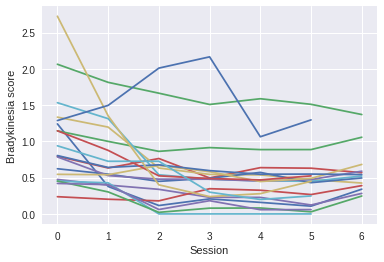

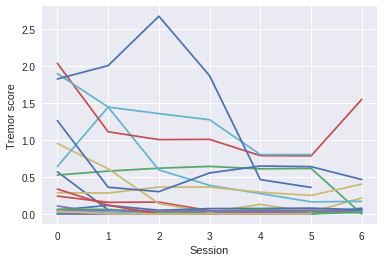

In [18]:
plt.figure()
for s in data.Subject.unique():
#     print(s,len(data[data.Subject==s].Visit.unique()))
    score = []
    for v in data.loc[data.Subject==s,'Visit'].unique():
        score.append(np.nanmean(data.loc[(data.Subject==s)&(data.Visit==v),'Bradykinesia'].values))
    
    plt.plot(score)

plt.xlabel('Session')
plt.ylabel('Bradykinesia score')

plt.figure()
for s in data.Subject.unique():
#     print(s,len(data[data.Subject==s].Visit.unique()))
    score = []
    for v in data.loc[data.Subject==s,'Visit'].unique():
        score.append(np.nanmean(data.loc[(data.Subject==s)&(data.Visit==v),'Tremor'].values))
    
    plt.plot(score)

plt.xlabel('Session')
plt.ylabel('Tremor score')


In [20]:
len(data)

33809

Plot clips with symptoms

In [106]:
dataP=data[data.Bradykinesia>1]
dataN=data[data.Bradykinesia==0]

Subject                                                      1004
Visit                                            2 Weeks: Time 90
Task                             Motor #3: Walking while Counting
Location                                        dorsal_hand_right
Bradykinesia                                                    0
Tremor                                                          0
Dyskinesia                                                      2
acc_xyz         [[0.3250171663996335, 1.0161898222323948, 0.01...
gyr_xyz         [[63.93530174715806, -17.66994735637445, 31.21...
Name: 8, dtype: object


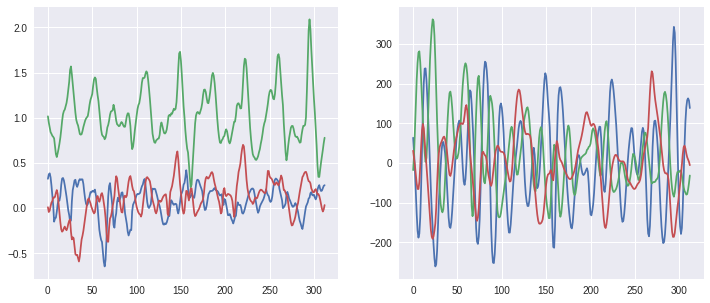

In [107]:
idx = np.random.choice(np.arange(len(dataP)),size=1)
d=dataN.iloc[int(idx)]
print(d)
fig=plt.figure(figsize=(12,5))
fig.add_subplot(121)
plt.plot(d.acc_xyz)
fig.add_subplot(122)
plt.plot(d.gyr_xyz)

In [16]:
# data['acclen']=data.apply()

In [18]:
subj

array([ 0,  0,  0, ..., 13, 13, 13])

### Resample data

In [44]:
#check clips with less than 313 samples and resample
la=[]; lg=[]
for i in range(len(acc)):
    la.append(acc[i].shape[0])
    lg.append(gyr[i].shape[0])

print(np.unique(lg))

#resample all clips to 313 samples (62.5 Hz)
# accres = []
num = 313
accres = np.zeros((len(acc),num,3) )
gyrres = np.zeros((len(gyr),num,3) )
for i in range(len(acc)):
    if len(acc[i]<num):
        accres[i,:,0] = resample(acc[i][:,0],num)
        accres[i,:,1] = resample(acc[i][:,1],num)
        accres[i,:,2] = resample(acc[i][:,2],num)
    else: 
        accres[i,:,:] = acc[i].copy()
        
    if len(gyr[i]<num):
        gyrres[i,:,0] = resample(gyr[i][:,0],num)
        gyrres[i,:,1] = resample(gyr[i][:,1],num)
        gyrres[i,:,2] = resample(gyr[i][:,2],num)
    else:
        gyrres[i,:,:] = acc[i].copy()

[297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313]


In [45]:
acc = accres
gyr = gyrres

In [46]:
def stdclipdata(X,plotdata=False):
    #standardize clips data by channel (for CNN)
    Xn = X.copy()
    x = np.reshape(X,(X.shape[0]*X.shape[1],X.shape[2]))
    m = np.mean(x,axis=0)
    s = np.std(x,axis=0)
    for c in range(X.shape[0]):
        for a in range(X.shape[2]):
            Xn[c,:,a]=(X[c,:,a]-m[a])/s[a]
    Xn.shape
    if plotdata:
        for i in range(0,5):
            print(np.mean(Xn[i],axis=0),np.std(X[i],axis=0))
            plt.plot(Xn[i])

    return Xn

In [47]:
accn = stdclipdata(acc,False)
gyrn = stdclipdata(gyr,False)

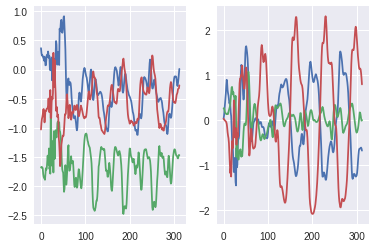

In [48]:
fig = plt.figure()
fig.add_subplot(121)
plt.plot(accn[0])
fig.add_subplot(122)
plt.plot(gyrn[0])

In [49]:
#save normalized clips
X = np.concatenate((accn,gyrn),axis=-1) #use acc and gyro data

In [50]:
np.save('Trainclips_FullDataset',X)

Train CNN using LOSO CV

## Train CNN on bradykinesia data
* accelerometer + gyro clips

In [80]:
!ls

AlterTimestamps.ipynb	     Models_GPU.ipynb
Clipsfiltered.hdf5	     PreprocessFcns.py
DataCleaning.ipynb	     __pycache__
DataPreprocessor2.ipynb      README.md
DataPreprocessorDebug.ipynb  Results
DataPreprocessor.ipynb	     ScoresAnalysis.ipynb
FeatureMatrix		     TaskVisualizer.ipynb
FFT_example.ipynb	     Trainclips_FullDataset.npy
Legacy Folder		     Trainclips.npy
Models			     Trainclips_unfiltered.npy
Models_GPU-AllLocs.ipynb


In [17]:
X = np.load('Trainclips_FullDataset.npy')
y = scores_brady.values
task = le.fit_transform(data.Task)
visit = le.fit_transform(data.Visit)
subj = le.fit_transform(data.Subject)
print(X.shape)
print(y.shape)
print(np.unique(subj))
print(np.unique(visit))

(33809, 313, 6)
(33809,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[0 1 2 3 4 5 6]


In [18]:
#remove rows (tasks) for which bradykinesia scores do not exists
indok = np.where(~np.isnan(y))[0]
X = X[indok,:,:]
y = y[indok]
task = task[indok]
visit = visit[indok]
subj = subj[indok]

In [19]:
print(X.shape)
print(y.shape)
print(task.shape)
print(visit.shape)
print(subj.shape)

(32268, 313, 6)
(32268,)
(32268,)
(32268,)
(32268,)


In [21]:
yreg = y.copy()
yclass = y.copy()
yclass[y>0] = 1

In [22]:
#binarize labels
y[y>0] = 1

## Data Augmentation
**Perform Data Augmentation - Random Rotations**

In [23]:
#rotate vector p around axis (0=x, 1=y, 2=z(orthogonal to sensor plane))
#vector p is 3x1"
def rot(th,p,axis=2):
    if axis == 0: #x-axis rot
        R = np.array([[1,0,0],[0, np.cos(th), -np.sin(th)],[0, np.sin(th), np.cos(th)]])
    if axis ==1: #y-axis rot
        R = np.array([[np.cos(th), 0, np.sin(th)],[0,1,0],[-np.sin(th), 0, np.cos(th)]])    
    if axis==2: #z-axis rot
        R = np.array([[np.cos(th), -np.sin(th), 0],[np.sin(th), np.cos(th), 0],[0,0,1]])

    pR = np.matmul(R,p)
    return pR,R

Subject            Visit               Task          Location  \
0     1004  2 Weeks: Time 0  Motor #2: Walking  dorsal_hand_left   
1     1004  2 Weeks: Time 0  Motor #2: Walking  dorsal_hand_left   

   Bradykinesia  Tremor  Dyskinesia  \
0           1.0     0.0         0.0   
1           1.0     0.0         0.0   

                                             acc_xyz  \
0  [[0.38654154268711416, -0.98970016021973, 0.21...   
1  [[-0.03558403906309593, -1.087968261234455, 0....   

                                             gyr_xyz  
0  [[2.410925459678083, 28.71747920958251, 1.8005...  
1  [[-54.41367208361953, 12.970168612191856, 110....

In [51]:
pi = np.pi
xR = []
xacc = X[:,:,:3]
for i in range(xacc.shape[0]):
    xR.append(rot(pi/2,xacc[i].T))
    
#scaling
x1 = xR[0][0]*(1+0.1*np.random.randn(1)[0])

(-3, 3)

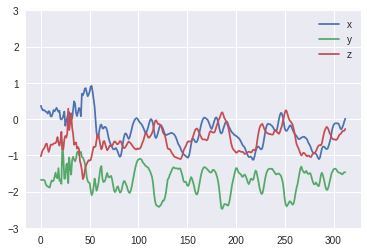

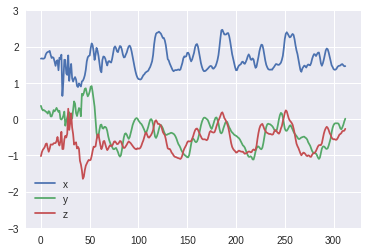

In [53]:
plt.plot(xacc[0,:,:3])
plt.legend(('x','y','z'))
plt.ylim([-3,3])
plt.figure()
plt.plot(xR[0][0].T)
# plt.plot(x1.T)
plt.legend(('x','y','z'))
plt.ylim([-3,3])

In [26]:
# th= np.pi/2
# # X_train[0,:,:,3:].squeeze().shape
# xaccR = rot(th,X_train[0,:,:,:3].squeeze().T)[0].T
# xgyrR = rot(th,X_train[0,:,:,3:].squeeze().T)[0].T
# print(xaccR.shape)
# xaccR = np.expand_dims(xaccR,axis=0)
# xgyrR = np.expand_dims(xgyrR,axis=0)
# XR = np.concatenate((xaccR,xgyrR),axis=2)
# print(XR.shape)
# print(X_train.shape)
# X_train[0,:,:,:] = XR
# # plt.plot(xaccR)
# # plt.figure()
# # plt.plot(X_train[0,:,:,3:].squeeze())
# # plt.legend(('x','y','z'))


Below the class to implement the data generator in Keras. Re-adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html

In [51]:
#test for data shift (overlapping windows)
# x0 = X_train[0,:,:,:]
# x1 = X_train[1,:,:,:]
# x = np.concatenate((x0,x1),axis=1)
# ind0 = int((0.5*np.random.rand(1)+0.25)*313) #pick random start time in clip 0
# print(ind0)
# Xnew = x[:,ind0:ind0+313] 
# plt.plot(x[0])
# plt.figure()
# plt.plot(Xnew[0])

In [26]:
#create Data Generator Class to apply random rotations to training data

class DataGenerator(object):

    #class init fcn
    def __init__(self, dim_x = 1, dim_y=313, dim_z = 6, batch_size=512, shuffle=True):
        'Initialization'
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.batch_size= batch_size
        self.shuffle = shuffle
    
    #Acutal generator method. Its structure is an infinite loop that goes through the dataset 
    #and outputs one batch at a time.
    def generate(self, X_train, labels):
         # Infinite loop
        while 1:
            # Generate batches
            indexes = np.arange(len(labels))
            #shuffle data
            if self.shuffle == True:
                np.random.shuffle(indexes)
            imax = int(len(indexes)/self.batch_size)
            for i in range(imax):
                #Find list of IDs for current batch
                list_IDs_temp = [indexes[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]

                #generate data (rotated)
                X,y = self.__data_generation(X_train,labels,list_IDs_temp)

                yield X,y


    #Private method: generates a random order of exploration for a given set of list_IDs (train indices)    
    def __get_exploration_order(self, list_IDs):
        '  Find exploration order'
        indexes = np.arange(len(list_IDs))
        if self.shuffle == True:
            np.random.shuffle(indexes)

        return indexes


    #outputs batches of data. The private method in charge of this task is called __data_generation and
    #only needs to know about the list of IDs included in batches as well as their corresponding labels.
    def __data_generation(self, X_train, labels, list_IDs_temp):
        num_classes = 2
        'Generates data of batch_size samples' # X : (n_samples, 1, time, n_channels)
        X = np.empty((self.batch_size, self.dim_x, self.dim_y, self.dim_z))
        y = np.empty((self.batch_size), dtype=int)

        #generate data
        for i, ID in enumerate(list_IDs_temp):
            
            #store batch data - DO NOT AUGMENT
#             X[i,:,:,:] = X_train[ID,:,:,:]

            #random rotation for current batch
            rax = np.random.randint(0,3) #select random axis to rotate around
            a = 5; b = 5 #min,max rotation (degrees)
            th=((b-a)*np.random.rand(1)+a)[0] #pick random angle
            th = np.pi*th/180
            xaccR = rot(th,X_train[ID,:,:,:3].squeeze().T,axis=rax)[0].T
            xgyrR = rot(th,X_train[ID,:,:,3:].squeeze().T,axis=rax)[0].T
            xaccR = np.expand_dims(xaccR,axis=0)
            xgyrR = np.expand_dims(xgyrR,axis=0)
            X[i,:,:,:] = np.concatenate((xaccR,xgyrR),axis=2)
            
            #generate new clip by overlapping 2 consecutive clips (shuffle must be set to False)
            if self.shuffle == False:
                x0 = X[i-1,:,:,:]
                x1 = X[i,:,:,:]
                x = np.concatenate((x0,x1),axis=1)
                ind0 = int((0.5*np.random.rand(1)+0.25)*self.dim_y) #pick random start time in clip 0
                Xnew = x[:,ind0:ind0+self.dim_y] 
                X[i,:,:,:] = Xnew
            
            #multiplicative noise (scaling)
            X[i,:,:,:] = X[i,:,:,:]*(1+0.05*np.random.randn(1)[0])

            #store labels
            y[i] = labels[ID]

        return X, keras.utils.to_categorical(y,num_classes)




### LOVO w Data augmentation

reshaping data for different models ...
CNN
X_train = 
(27148, 1, 313, 6)
model training ... - eval on visit [0]
Epoch 1/30
53/53 [==============================] - 3s - loss: 0.7691 - acc: 0.5112 - val_loss: 0.6870 - val_acc: 0.6645
Epoch 2/30
53/53 [==============================] - 3s - loss: 0.6870 - acc: 0.5438 - val_loss: 0.6788 - val_acc: 0.7006
Epoch 3/30
53/53 [==============================] - 3s - loss: 0.6661 - acc: 0.5944 - val_loss: 0.6432 - val_acc: 0.7063
Epoch 4/30
53/53 [==============================] - 3s - loss: 0.6460 - acc: 0.6271 - val_loss: 0.6234 - val_acc: 0.7090
Epoch 5/30
53/53 [==============================] - 3s - loss: 0.6304 - acc: 0.6403 - val_loss: 0.6036 - val_acc: 0.7092
Epoch 6/30
53/53 [==============================] - 3s - loss: 0.6196 - acc: 0.6520 - val_loss: 0.5956 - val_acc: 0.7121
Epoch 7/30
53/53 [==============================] - 2s - loss: 0.6136 - acc: 0.6618 - val_loss: 0.5826 - val_acc: 0.7119
Epoch 8/30
53/53 [======================

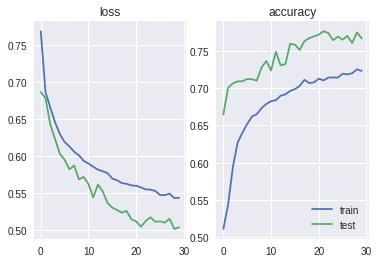

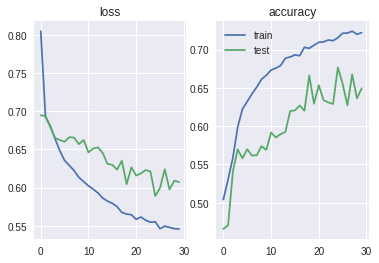

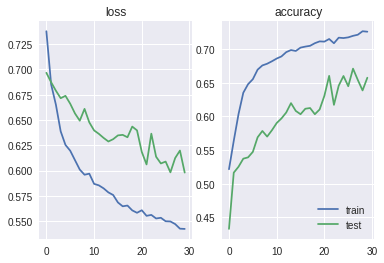

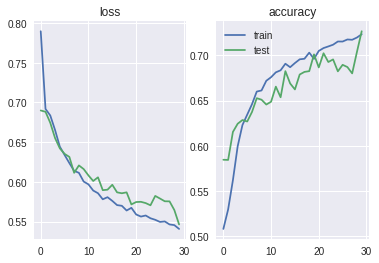

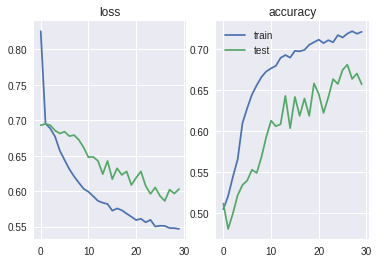

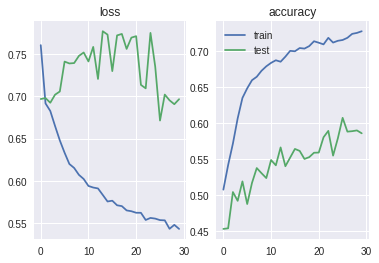

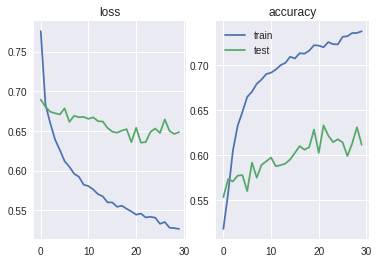

In [27]:
from numpy.random import seed
seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)

#specifying hyper-parameters
batch_size = 512 
num_classes = 2  
rec_task = pd.DataFrame()
params = {'dim_x':1, 'dim_y':313, 'dim_z':6, 'batch_size':batch_size, 'shuffle':True} #generator class params

#split by subject and loop 
loso = LeaveOneGroupOut()
f1all=[]; auprcall=[]; aurocall=[]; rec_all=[]; spec_all=[]; fpr_all=[]; tpr_all=[]
for train_index, test_index in loso.split(X, y, visit):
    
    RecS=[] #store recall per task
    
    current_visit = np.unique(visit[test_index])
    
#     if current_visit != 0:
#         continue
        
    task_subj = task[test_index] #tasks for current visit

    X_train = X[train_index]; y_train = y[train_index]
    X_valid = X[test_index]; y_valid = y[test_index]  

    # convert class vectors to binary class matrices
#     y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)

    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type='CNN')
    print('X_train = ')
    #swap axes to have channel as last dim
    X_train = np.swapaxes(X_train,1,3)
    X_valid = np.swapaxes(X_valid,1,3)
    print(X_train.shape)

    #model
    model=buildCNN(win_len,dim)
    print('model training ... - eval on visit %s'%current_visit)
    epochs = 30
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
    #Initialize DataGenerator object
    trainIDs = list(np.arange(X_train.shape[0]))
    training_generator = DataGenerator(shuffle=True).generate(X_train,y_train)

    hist=model.fit_generator(generator=training_generator, epochs=epochs, steps_per_epoch=len(trainIDs)//batch_size,
                            validation_data=(X_valid,y_valid),verbose=1)
    #metrics
    f1,Rec,Spec,auprc,auroc,fpr,tpr=model_eval(X_valid,y_valid)
    f1all.append(f1)
    auprcall.append(auprc)
    aurocall.append(auroc)
    rec_all.append(Rec)
    spec_all.append(Spec)
    fpr_all.append(fpr); tpr_all.append(tpr)
  

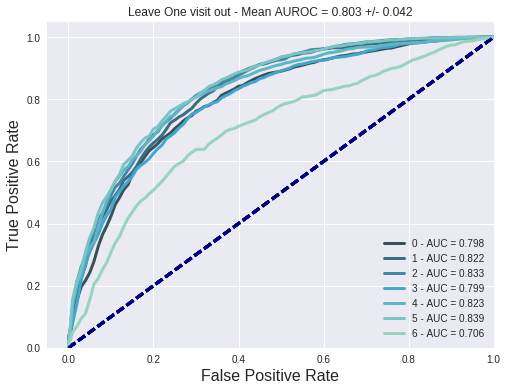

In [60]:
current_palette=sns.color_palette("GnBu_d", len(aurocall))
plt.figure(figsize=(8,6))

for v in range(len(aurocall)):
    
    AX=plot_roc(tpr_all[v],fpr_all[v],aurocall[v],ax=None,plotname=v,col=current_palette[v])
plt.title('Leave One visit out - Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))

### Leave one visit out - No Data Augmentation

reshaping data for different models ...
CNN
X_train = 
(23705, 1, 313, 6)
model training ... - eval on visit [0]
f1_test=0.782, Prec=0.842, Rec=0.730, Spec=0.708, auprc=0.877, auroc=0.790
[[1156  477]
 [ 943 2544]]
reshaping data for different models ...
CNN
X_train = 
(24096, 1, 313, 6)
model training ... - eval on visit [1]
f1_test=0.712, Prec=0.596, Rec=0.883, Spec=0.547, auprc=0.771, auroc=0.814
[[1473 1218]
 [ 239 1799]]
reshaping data for different models ...
CNN
X_train = 
(24160, 1, 313, 6)
model training ... - eval on visit [2]
f1_test=0.723, Prec=0.640, Rec=0.832, Spec=0.668, auprc=0.767, auroc=0.829
[[1824  907]
 [ 325 1609]]
reshaping data for different models ...
CNN
X_train = 
(23979, 1, 313, 6)
model training ... - eval on visit [3]
f1_test=0.778, Prec=0.784, Rec=0.771, Spec=0.698, auprc=0.819, auroc=0.793
[[1395  604]
 [ 651 2196]]
reshaping data for different models ...
CNN
X_train = 
(24103, 1, 313, 6)
model training ... - eval on visit [4]
f1_test=0.738, Prec=0.700, 

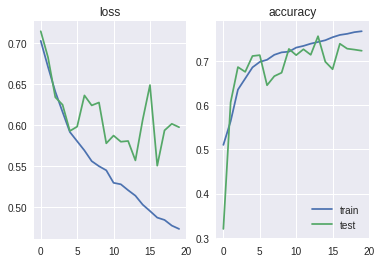

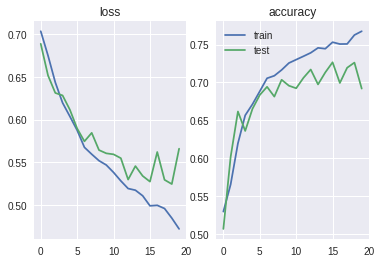

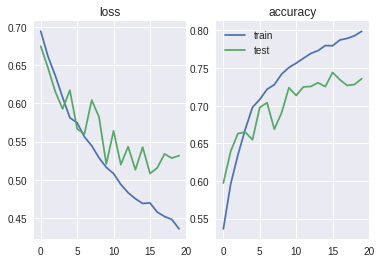

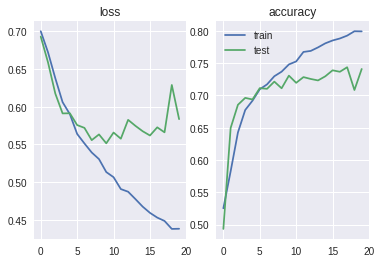

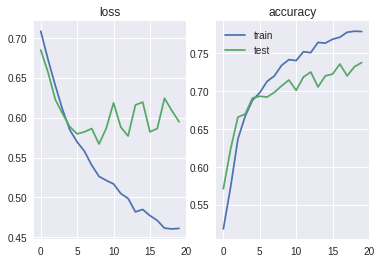

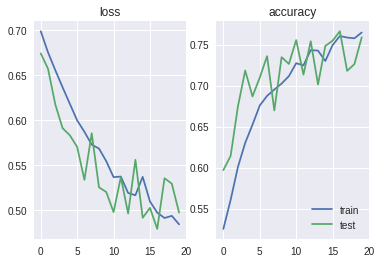

In [32]:
#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16
num_classes = 2 # 
rec_task = pd.DataFrame()

#split by subject and loop 
loso = LeaveOneGroupOut()
f1all=[]; auprcall=[]; aurocall=[]; rec_all=[]; spec_all=[]; fpr_all=[]; tpr_all=[]
for train_index, test_index in loso.split(X, y, visit):
    
    RecS=[] #store recall per task
    
    current_visit = np.unique(visit[test_index])
    task_subj = task[test_index] #tasks for current visit

    X_train = X[train_index]; y_train = y[train_index]
    X_valid = X[test_index]; y_valid = y[test_index]  

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)

    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type='CNN')
    print('X_train = ')
    #swap axes to have channel as last dim
    X_train = np.swapaxes(X_train,1,3)
    X_valid = np.swapaxes(X_valid,1,3)
    print(X_train.shape)

    #model
    model=buildCNN(win_len,dim)
    print('model training ... - eval on visit %s'%current_visit)
    epochs = 20
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
    hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid),verbose=0)
    f1,Rec,Spec,auprc,auroc,fpr,tpr=model_eval(X_valid,y_valid)
    f1all.append(f1)
    auprcall.append(auprc)
    aurocall.append(auroc)
    rec_all.append(Rec)
    spec_all.append(Spec)
    fpr_all.append(fpr); tpr_all.append(tpr)
    
    #store recall per task
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    y_valid = np.argmax(y_valid,axis=1)
    for t in np.unique(task_subj):
        
        ind_task = task_subj==t
        ypred_s = y_pred[ind_task]
        ytrue_s = y_valid[ind_task]
        TP=sum(ypred_s[ytrue_s==1])
        P = sum(ytrue_s == 1)
        RecS.append(TP/P)
        
    rec_task[current_visit[0]]=np.asarray(RecS)


        

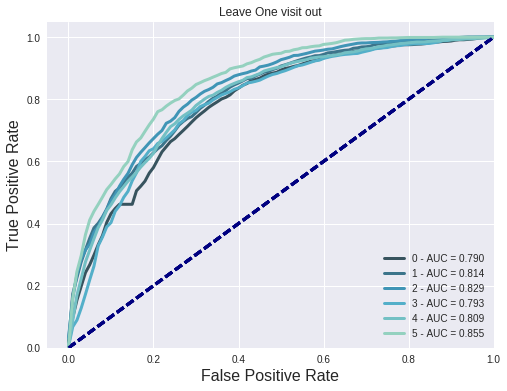

In [35]:
current_palette=sns.color_palette("GnBu_d", len(aurocall))
plt.figure(figsize=(8,6))

for v in range(len(aurocall)):
    
    AX=plot_roc(tpr_all[v],fpr_all[v],aurocall[v],ax=None,plotname=v,col=current_palette[v])
plt.title('Leave One visit out')

In [40]:
#save current model weights
model.save('./Models/model_brady_LOVO_2.h5')

In [41]:
Results = {'f1':f1all, 'recall':rec_all, 'spec':spec_all, 'auroc':aurocall, 'auprc':auprcall, 'rec_task':rec_task,
          'TPR':tpr_all,'FPR':fpr_all}
np.save('./Results/Brady_results_2.npy',Results)

In [20]:
Results=np.load('./Results/Brady_results.npy')

In [26]:
t = np.unique(task)
rec_task = Results.item()['rec_task']
rec_task.index=tasknames[t]
aurocall = Results.item()['auroc']

In [27]:
print(np.mean(Results.item()['recall']),np.std(Results.item()['recall']))

0.7947170193095848 0.05689801464469766


In [28]:
print(np.mean(Results.item()['spec']),np.std(Results.item()['spec']))

0.6664836189367006 0.0714032707408531


In [29]:
print(np.mean(Results.item()['auroc']),np.std(Results.item()['auroc']))

0.8103757344860568 0.04669995652023568


In [38]:
np.median(aurocall)

0.8284381382207437

In [24]:
le = LabelEncoder()
taskcodes = le.fit_transform(data.Task)
taskcodes = np.unique(taskcodes)
tasknames = le.inverse_transform(taskcodes)

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [25]:
print(list(zip(taskcodes,tasknames)))

[(0, 'Motor #10: Drinking Water'), (1, 'Motor #11: Organizing Folder'), (2, 'Motor #12: Folding Towels'), (3, 'Motor #2: Walking'), (4, 'Motor #3: Walking while Counting'), (5, 'Motor #4: Finger to Nose'), (6, 'Motor #5: Alternating Hand Movements'), (7, 'Motor #6: Sit to Stand'), (8, 'Motor #7: Drawing on Paper'), (9, 'Motor #8: Typing on a Computer'), (10, 'Motor #9: Nuts and Bolts')]


In [22]:
l = list(zip(taskcodes,tasknames))

In [43]:
rec_task

0         1         2         3  \
Motor #10: Drinking Water             0.860714  0.805755  0.914894  0.787500   
Motor #11: Organizing Folder          0.706522  0.558333  0.791489  0.643110   
Motor #12: Folding Towels             0.582353  0.693548  0.843373  0.738318   
Motor #2: Walking                     0.847059  0.860465  0.955975  0.852941   
Motor #3: Walking while Counting      0.851562  0.853801  0.971751  0.867347   
Motor #4: Finger to Nose              0.770833  0.770492  0.956522  0.783333   
Motor #5: Alternating Hand Movements  0.770349  0.849057  0.838384  0.888430   
Motor #7: Drawing on Paper            0.885350  0.804124  0.837209  0.883721   
Motor #8: Typing on a Computer        0.946768  0.593607  0.860465  0.725000   
Motor #9: Nuts and Bolts              0.862661  0.917476  0.885714  0.788288   

                                             4         5         6  
Motor #10: Drinking Water             0.827869  0.864286  0.700000  
Motor #11: Organizing Folder          0.609244  0.582645  0.623932  
Motor #12: Folding Towels             0.585635  0.789744  0.663121  
Motor #2: Walking                     0.967949  0.925714  0.668478  
Motor #3: Walking while Counting      0.960199  0.955801  0.768116  
Motor #4: Finger to Nose              0.717949  0.928571  0.433333  
Motor #5: Alternating Hand Movements  0.978947  0.866071  0.791667  
Motor #7: Drawing on Paper            0.728972  1.000000  0.800000  
Motor #8: Typing on a Computer        0.795122  0.890173  0.541850  
Motor #9: Nuts and Bolts              0.861244  0.906250  0.859813

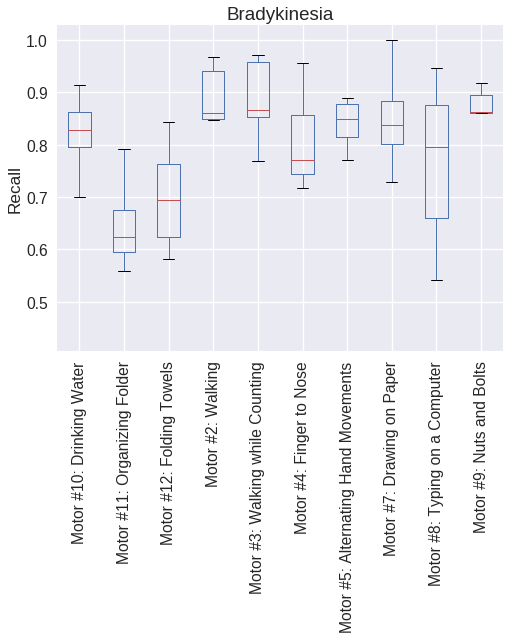

In [44]:
sns.set_context('talk',font_scale=1.2)
plt.figure(figsize=(8,6))
rec_task.T.boxplot(rot=90)
plt.ylabel('Recall')
plt.title('Bradykinesia')

In [88]:
from scipy.stats import wilcoxon

In [89]:
rec_task.T.median()

Motor #10: Drinking Water               0.827869
Motor #11: Organizing Folder            0.623932
Motor #12: Folding Towels               0.693548
Motor #2: Walking                       0.860465
Motor #3: Walking while Counting        0.867347
Motor #4: Finger to Nose                0.770833
Motor #5: Alternating Hand Movements    0.849057
Motor #7: Drawing on Paper              0.837209
Motor #8: Typing on a Computer          0.795122
Motor #9: Nuts and Bolts                0.862661
dtype: float64

## LOSO CV

reshaping data for different models ...
CNN
X_train = 
(30668, 1, 313, 6)
model training ... - eval on subj [0]
f1_test=0.538, Prec=0.461, Rec=0.645, Spec=0.622, auprc=0.490, auroc=0.688
[[664 403]
 [189 344]]
reshaping data for different models ...
CNN
X_train = 
(30418, 1, 313, 6)
model training ... - eval on subj [1]
f1_test=0.751, Prec=0.974, Rec=0.611, Spec=0.823, auprc=0.977, auroc=0.832
[[ 130   28]
 [ 658 1034]]
reshaping data for different models ...
CNN
X_train = 
(30570, 1, 313, 6)
model training ... - eval on subj [2]
f1_test=0.716, Prec=0.690, Rec=0.745, Spec=0.557, auprc=0.758, auroc=0.711
[[407 324]
 [247 720]]
reshaping data for different models ...
CNN
X_train = 
(30478, 1, 313, 6)
model training ... - eval on subj [3]
f1_test=0.665, Prec=0.526, Rec=0.906, Spec=0.673, auprc=0.731, auroc=0.876
[[861 418]
 [ 48 463]]
reshaping data for different models ...
CNN
X_train = 
(30468, 1, 313, 6)
model training ... - eval on subj [4]
f1_test=0.618, Prec=0.753, Rec=0.523, Spec=0

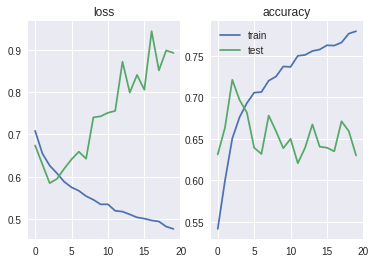

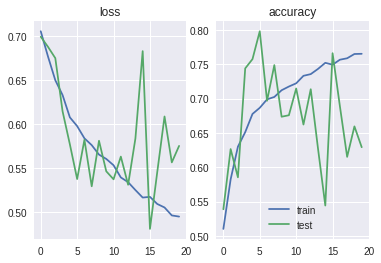

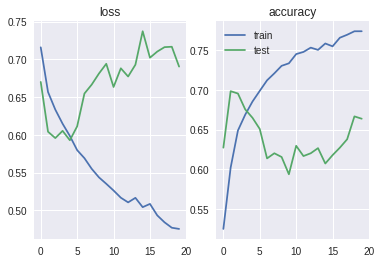

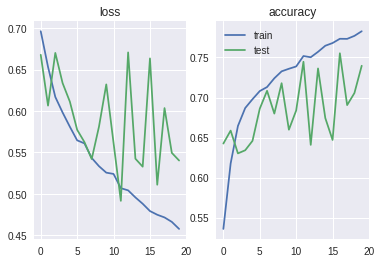

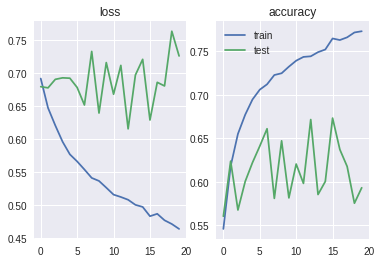

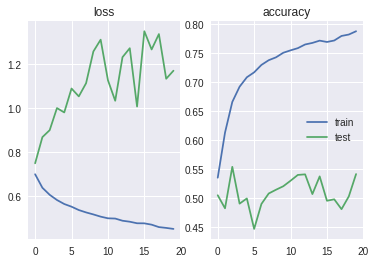

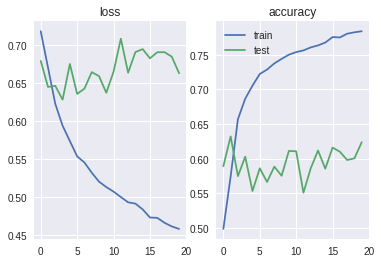

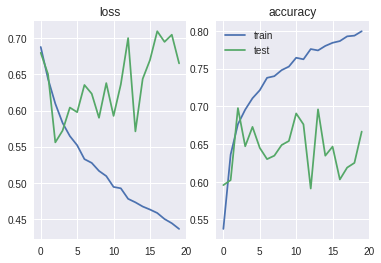

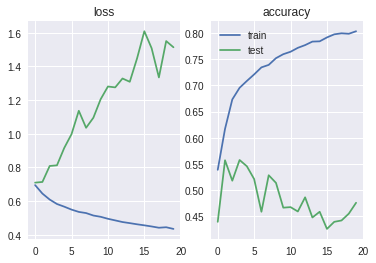

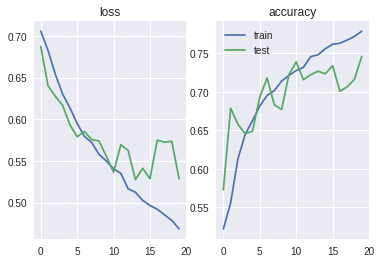

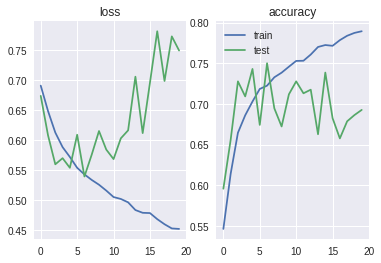

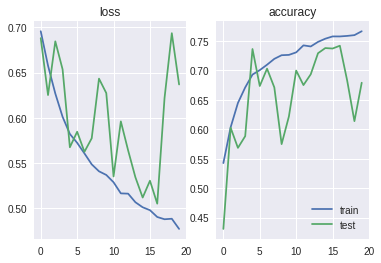

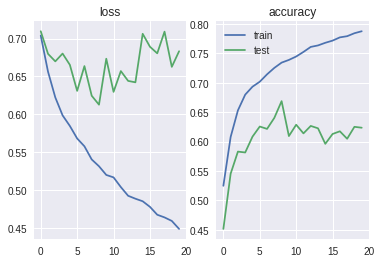

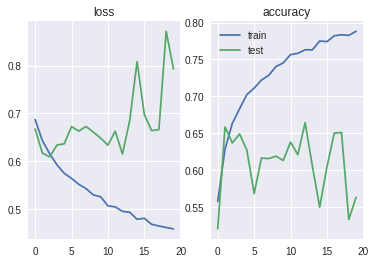

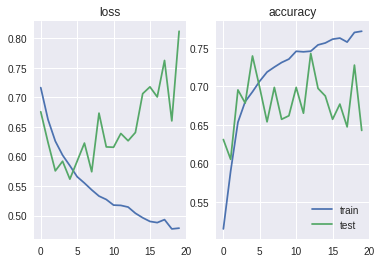

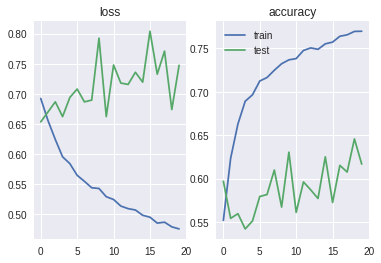

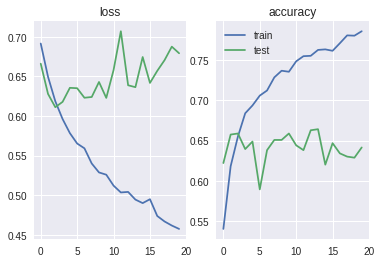

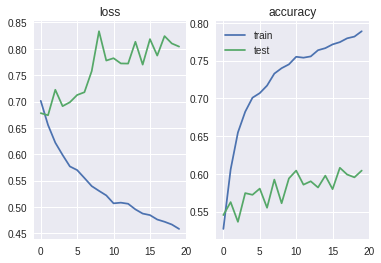

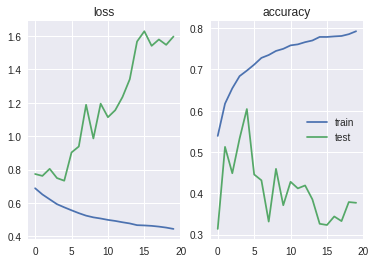

In [27]:
#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16
num_classes = 2 # 
rec_task = pd.DataFrame()

#split by subject and loop 
loso = LeaveOneGroupOut()
f1all=[]; auprcall=[]; aurocall=[]; fpr_all=[]; tpr_all=[]
for train_index, test_index in loso.split(X, y, subj):
    
    RecS=[] #store recall per task
    
    current_subj = np.unique(subj[test_index])
    task_subj = task[test_index] #tasks for current subj

    X_train = X[train_index]; y_train = y[train_index]
    X_valid = X[test_index]; y_valid = y[test_index]  

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)

    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type='CNN')
    print('X_train = ')
    #swap axes to have channel as last dim
    X_train = np.swapaxes(X_train,1,3)
    X_valid = np.swapaxes(X_valid,1,3)
    print(X_train.shape)

    #model
    model=buildCNN(win_len,dim)
    print('model training ... - eval on subj %s'%current_subj)
    epochs = 20
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
    hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid),verbose=0)
    f1,Rec,Spec,auprc,auroc,fpr,tpr=model_eval(X_valid,y_valid)
    f1all.append(f1)
    auprcall.append(auprc)
    aurocall.append(auroc)
    fpr_all.append(fpr); tpr_all.append(tpr)
    
    #store recall per task
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    y_valid = np.argmax(y_valid,axis=1)
    for t in np.unique(task_subj):
        
        ind_task = task_subj==t
        ypred_s = y_pred[ind_task]
        ytrue_s = y_valid[ind_task]
        TP=sum(ypred_s[ytrue_s==1])
        P = sum(ytrue_s == 1)
        RecS.append(TP/P)
        
    rec_task[current_subj[0]]=np.asarray(RecS)

        

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


(0.45, 1.0)

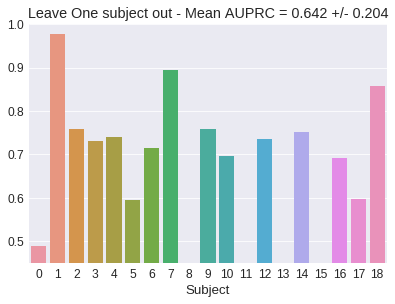

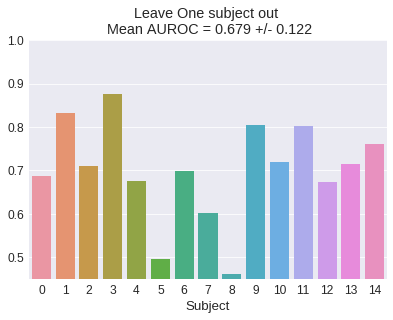

In [38]:
sns.set_context('paper',font_scale=1.5)
# plt.figure()
# ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=f1all)
# plt.title('f1 score')
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=auprcall)
plt.title('AUPRC')
plt.xlabel('Subject')
plt.title('Leave One subject out - Mean AUPRC = %.3f +/- %.3f'%(np.mean(auprcall),np.std(auprcall)))
plt.ylim([0.45,1.])
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj)))[:15],y=aurocall[:15])
plt.title('AUROC')
plt.xlabel('Subject')
plt.title('Leave One subject out \n Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))
plt.ylim([0.45,1.])

Batch norm does not improve results nor stabilize performance on valid set

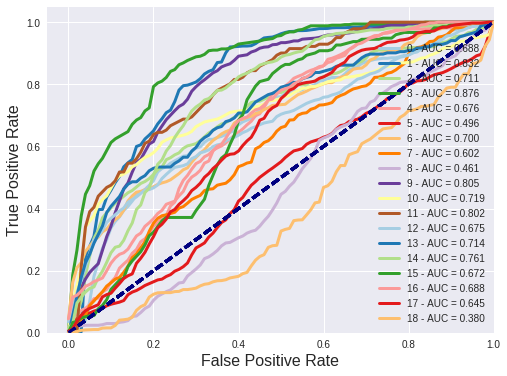

In [32]:
#AUROC SUBJ-WISE
current_palette=sns.color_palette("Paired", len(aurocall))
plt.figure(figsize=(8,6))

for v in range(len(aurocall)):
    AX=plot_roc(tpr_all[v],fpr_all[v],aurocall[v],ax=None,plotname=v,col=current_palette[v])

In [145]:
# P_ratio=[];meanscore=[]
# for train_index, test_index in loso.split(X, y, subj):
#     P_ratio.append(sum(y[test_index]==1)/len(y[test_index]))        
# ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=P_ratio)
# plt.ylabel('Mean Score')

# from scipy.stats import pearsonr

In [144]:
# plt.scatter(x=P_ratio,y=aurocall)
# pearsonr(P_ratio,auprcall)
# plt.xlabel('Mean Score')
# plt.ylabel('AUROC')

In [152]:
le = LabelEncoder()
taskcodes = le.fit_transform(data.Task)
taskcodes = np.unique(taskcodes)
tasknames = le.inverse_transform(taskcodes)

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [161]:
tasknames[t]

array(['Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
       'Motor #12: Folding Towels', 'Motor #2: Walking',
       'Motor #3: Walking while Counting', 'Motor #4: Finger to Nose',
       'Motor #5: Alternating Hand Movements',
       'Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer',
       'Motor #9: Nuts and Bolts'], dtype=object)

In [158]:
t = np.unique(task)


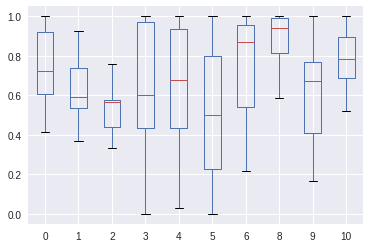

In [146]:
rec_task.index = np.unique(task_subj)
rec_task.T.boxplot()

## LOSO CV w data augmentation

In [98]:
len(trainIDs)

23705

reshaping data for different models ...
CNN
X_train = 
(27439, 1, 313, 6)
model training ... - eval on subj [0]
f1_test=0.527, Prec=0.466, Rec=0.604, Spec=0.657, auprc=0.509, auroc=0.647
[[608 318]
 [182 278]]
reshaping data for different models ...
CNN
X_train = 
(27237, 1, 313, 6)
model training ... - eval on subj [1]
f1_test=0.812, Prec=0.985, Rec=0.690, Spec=0.897, auprc=0.980, auroc=0.886
[[130  15]
 [447 996]]
reshaping data for different models ...
CNN
X_train = 
(27375, 1, 313, 6)
model training ... - eval on subj [2]
f1_test=0.656, Prec=0.680, Rec=0.634, Spec=0.596, auprc=0.793, auroc=0.696
[[368 249]
 [305 528]]
reshaping data for different models ...
CNN
X_train = 
(27307, 1, 313, 6)
model training ... - eval on subj [3]
f1_test=0.641, Prec=0.503, Rec=0.884, Spec=0.642, auprc=0.725, auroc=0.855
[[691 386]
 [ 51 390]]
reshaping data for different models ...
CNN
X_train = 
(27281, 1, 313, 6)
model training ... - eval on subj [4]
f1_test=0.630, Prec=0.722, Rec=0.559, Spec=0.580

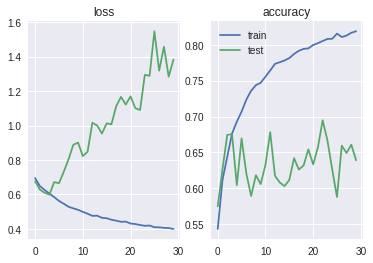

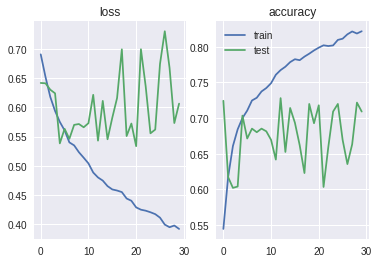

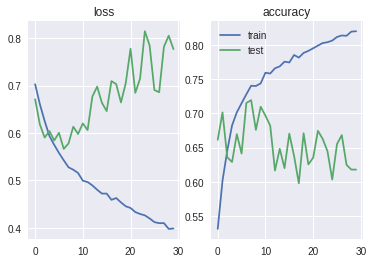

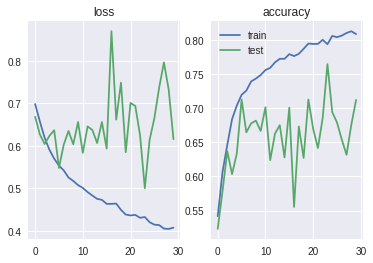

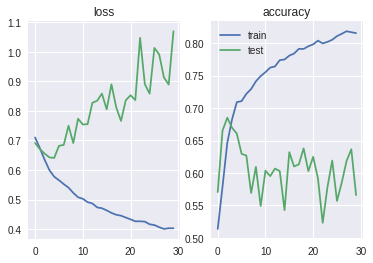

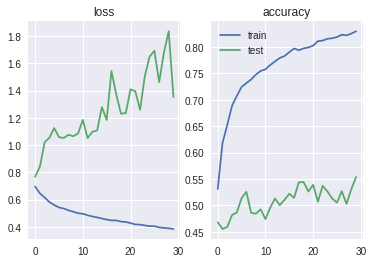

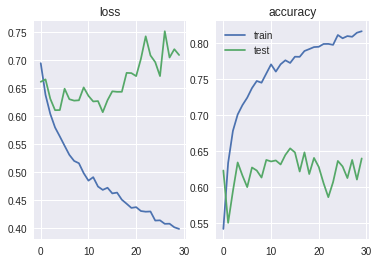

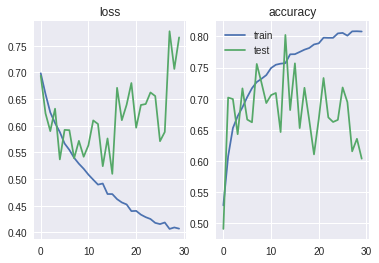

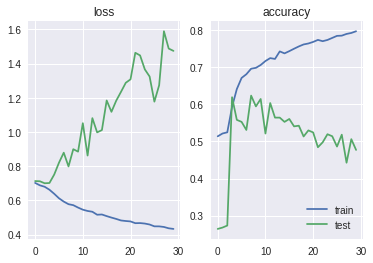

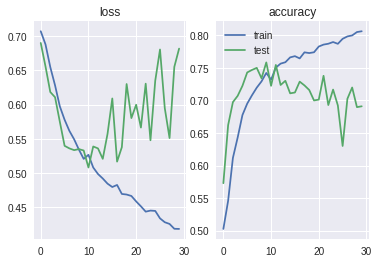

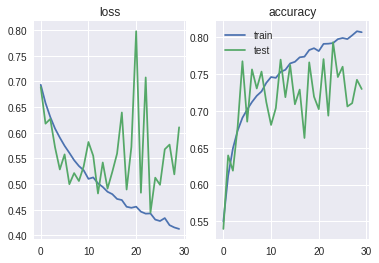

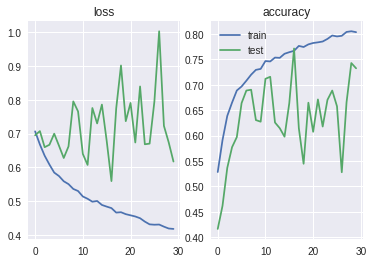

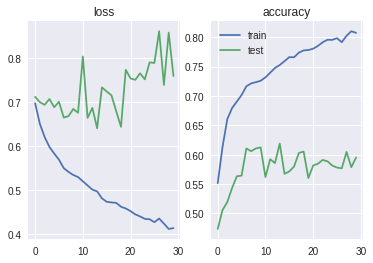

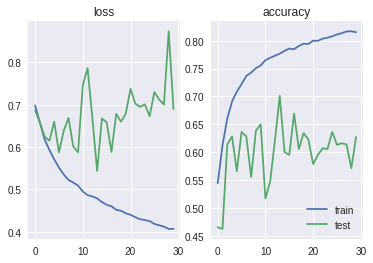

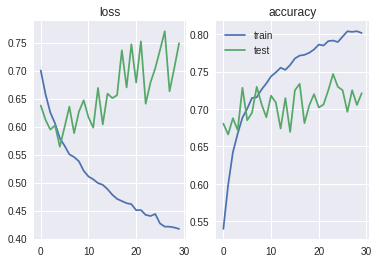

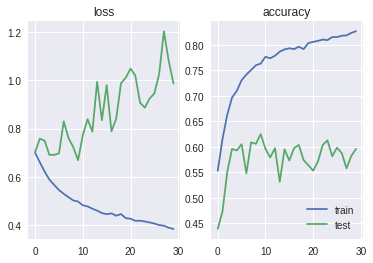

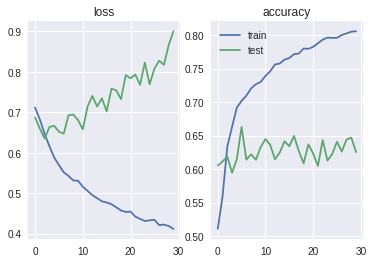

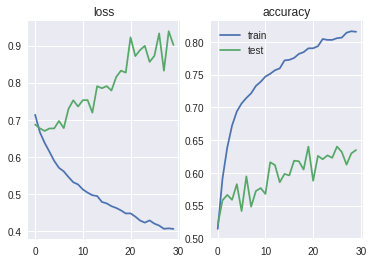

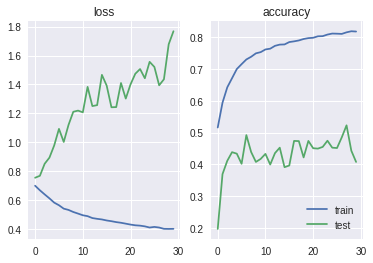

In [100]:
#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16
num_classes = 2 # 
rec_task = pd.DataFrame()
params = {'dim_x':1, 'dim_y':313, 'dim_z':6, 'batch_size':batch_size, 'shuffle':True} #generator class params

#split by subject and loop 
loso = LeaveOneGroupOut()
f1all=[]; auprcall=[]; aurocall=[]; fpr_all=[]; tpr_all=[]
for train_index, test_index in loso.split(X, y, subj):
    
    RecS=[] #store recall per task
    
    current_subj = np.unique(subj[test_index])
    task_subj = task[test_index] #tasks for current subj

    X_train = X[train_index]; y_train = y[train_index]
    X_valid = X[test_index]; y_valid = y[test_index]  

    # convert class vectors to binary class matrices
#     y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)

    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type='CNN')
    print('X_train = ')
    #swap axes to have channel as last dim
    X_train = np.swapaxes(X_train,1,3)
    X_valid = np.swapaxes(X_valid,1,3)
    print(X_train.shape)

    #model
    model=buildCNN(win_len,dim)
    print('model training ... - eval on subj %s'%current_subj)
    epochs = 30
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
    #Initialize DataGenerator object
    trainIDs = list(np.arange(X_train.shape[0]))
    training_generator = DataGenerator(shuffle=True).generate(X_train,y_train)

    hist=model.fit_generator(generator=training_generator, epochs=epochs, steps_per_epoch=len(trainIDs)//batch_size,
                            validation_data=(X_valid,y_valid),verbose=0)
    #metrics
    f1,Rec,Spec,auprc,auroc,fpr,tpr=model_eval(X_valid,y_valid)
    f1all.append(f1)
    auprcall.append(auprc)
    aurocall.append(auroc)
    fpr_all.append(fpr); tpr_all.append(tpr)
    
    #store recall per task
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    y_valid = np.argmax(y_valid,axis=1)
    for t in np.unique(task_subj):
        
        ind_task = task_subj==t
        ypred_s = y_pred[ind_task]
        ytrue_s = y_valid[ind_task]
        TP=sum(ypred_s[ytrue_s==1])
        P = sum(ytrue_s == 1)
        RecS.append(TP/P)
        
    rec_task[current_subj[0]]=np.asarray(RecS)

        

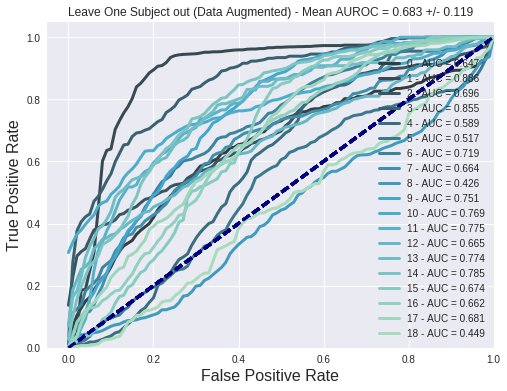

In [101]:
#AUROC SUBJ-WISE
current_palette=sns.color_palette("GnBu_d", len(aurocall))
plt.figure(figsize=(8,6))

for v in range(len(aurocall)):
    AX=plot_roc(tpr_all[v],fpr_all[v],aurocall[v],ax=None,plotname=v,col=current_palette[v])

plt.title('Leave One Subject out (Data Augmented) - Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))

## Transfer Learning 
train on all subjects but one and refine on 1 session of the target subject

In [31]:
def buildCNN(win_len,dim):
    num_classes = 2  

    model=Sequential()
    model.add(Conv2D(filters=16, kernel_size=(1, 32),activation='relu',input_shape=(1, win_len, dim),padding='same'))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 4)))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=16, kernel_size=(1, 16), activation='relu',padding='same'))
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 6)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
#     model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
        
    return model

In [18]:
X = np.load('Trainclips_FullDataset.npy')
y = scores_brady.values
task = le.fit_transform(data.Task)
visit = le.fit_transform(data.Visit)
subj = le.fit_transform(data.Subject)
#remove rows (tasks) for which bradykinesia scores do not exists
indok = np.where(~np.isnan(y))[0]
X = X[indok,:,:]
y = y[indok]
task = task[indok]
visit = visit[indok]
subj = subj[indok]
print(X.shape)
print(y.shape)
print(np.unique(subj))
print(np.unique(visit))
#binarize labels
y[y>0] = 1

(33809, 313, 6)
(33809,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[0 1 2 3 4 5 6]


In [82]:
visit_ft = visit[subj==losub]

In [36]:
X_all = X.copy()

reshaping data for different models ...
CNN
X_train = 
(27160, 1, 313, 6)


INFO (theano.gof.compilelock): Refreshing lock /home/luca/.theano/compiledir_Linux-3.16--generic-x86_64-with-debian-jessie-sid-x86_64-3.6.0-64/lock_dir/lock


model training ...
Epoch 1/30
53/53 [==============================] - 3s - loss: 0.7457 - acc: 0.5296 - val_loss: 0.6871 - val_acc: 0.5567
Epoch 2/30
53/53 [==============================] - 3s - loss: 0.6683 - acc: 0.5897 - val_loss: 0.6674 - val_acc: 0.5737
Epoch 3/30
53/53 [==============================] - 3s - loss: 0.6389 - acc: 0.6345 - val_loss: 0.6571 - val_acc: 0.5789
Epoch 4/30
53/53 [==============================] - 3s - loss: 0.6132 - acc: 0.6603 - val_loss: 0.6574 - val_acc: 0.5760
Epoch 5/30
53/53 [==============================] - 3s - loss: 0.6022 - acc: 0.6719 - val_loss: 0.6634 - val_acc: 0.5606
Epoch 6/30
53/53 [==============================] - 3s - loss: 0.5873 - acc: 0.6840 - val_loss: 0.6570 - val_acc: 0.5676
Epoch 7/30
53/53 [==============================] - 3s - loss: 0.5780 - acc: 0.6905 - val_loss: 0.6620 - val_acc: 0.5638
Epoch 8/30
53/53 [==============================] - 3s - loss: 0.5712 - acc: 0.6998 - val_loss: 0.6415 - val_acc: 0.5859
Epoch 9/30
53

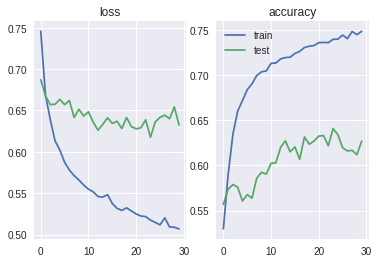

In [40]:
#1. Select subject i to fine tune the model
#2. Train the model on all other subjects - Validation data is Session 6 (4 weeks)
#3. Freeze Conv layers
#4. Replace Fully connected layer with a new layer
#5. Train FC model on data from subject i 


#Train Global model 
#specifying hyper-parameters
batch_size = 512 #1024
num_classes = 2 # 
params = {'dim_x':1, 'dim_y':313, 'dim_z':6, 'batch_size':batch_size, 'shuffle':True} #generator class params

#select left out subject
losub = 5
#data from subject for fine tuning
X_finetune = X[subj==losub].copy()
y_finetune = y[subj==losub].copy()
visit_ft = visit[subj==losub]
#Train/Dev set global model
X_others = X[subj!=losub]
y_others = y[subj!=losub]
visit_others = visit[subj!=losub] #visit session indices
X_train = X_others[visit_others != 6]
y_train = y_others[visit_others != 6]
X_valid = X_others[visit_others == 6]
y_valid = y_others[visit_others == 6]

# convert class vectors to binary class matrices
#     y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

#format data for specific network
_, win_len, dim = X.shape
print('reshaping data for different models ...')
X_train, X_valid = _data_reshaping(X_train, X_valid, network_type='CNN')
print('X_train = ')
#swap axes to have channel as last dim
X_train = np.swapaxes(X_train,1,3)
X_valid = np.swapaxes(X_valid,1,3)
print(X_train.shape)

#model
model=buildCNN(win_len,dim)
print('model training ...')
epochs = 30
model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
#Initialize DataGenerator object
trainIDs = list(np.arange(X_train.shape[0]))
training_generator = DataGenerator(shuffle=True).generate(X_train,y_train)

hist=model.fit_generator(generator=training_generator, epochs=epochs, steps_per_epoch=len(trainIDs)//batch_size,
                        validation_data=(X_valid,y_valid),verbose=1)

#predict on left out subject
print('Predicting on left out subject')
X_finetune=np.expand_dims(X_finetune,axis=1)
f1,Rec,Spec,auprc,auroc,fpr,tpr=model_eval(X_finetune,keras.utils.to_categorical(y_finetune, num_classes))

f1_test=0.657, Prec=0.577, Rec=0.763, Spec=0.198, auprc=0.614, auroc=0.509
[[162 658]
 [278 897]]


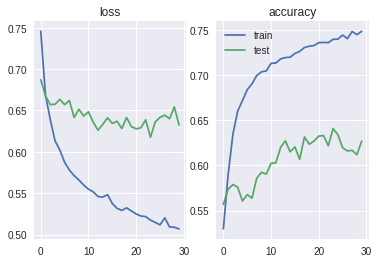

In [53]:
#predict on left out subject
f1,Rec,Spec,auprc,auroc,fpr,tpr=model_eval(X_finetune,keras.utils.to_categorical(y_finetune, num_classes))

In [55]:
model.save('./Models/model_ft.h5') #save model trained on other subjects

In [108]:
from keras.models import load_model
model_loaded = load_model('./Models/model_ft.h5')

In [109]:

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 1, 313, 16)        3088      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 1, 78, 16)         0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 1, 78, 16)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 1, 78, 16)         4112      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 1, 13, 16)         0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 1, 13, 16)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 208)               0         
__________

In [110]:
#train/dev set
Xft_train = X_finetune[visit_ft==0]
yft_train = y_finetune[visit_ft==0]
Xft_valid = X_finetune[visit_ft!=0]
yft_valid = y_finetune[visit_ft!=0]
yft_valid = keras.utils.to_categorical(yft_valid, num_classes)
print(Xft_train.shape)
print(Xft_valid.shape)
print(yft_train.shape)
print(yft_valid.shape)

(284, 1, 313, 6)
(1711, 1, 313, 6)
(284,)
(1711, 2)


In [111]:
#fine tuning
model.layers.pop()

In [112]:
#not sure what the first 2 lines are for
model.outputs = [model.layers[-1].output]
model.layers[-1].outbound_nodes = []
model.add(Dense(num_classes, activation='softmax'))

In [113]:
for layer in model.layers[:-1]:
    layer.trainable = False

In [116]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [117]:
#Initialize DataGenerator object
trainIDs = list(np.arange(Xft_train.shape[0]))
training_generator = DataGenerator(shuffle=True).generate(Xft_train,yft_train)

hist=model.fit_generator(generator=training_generator, epochs=epochs, steps_per_epoch=len(trainIDs)//batch_size,
                        validation_data=(Xft_valid,yft_valid),verbose=1)


KeyboardInterrupt: 

f1_test=0.930, Prec=0.882, Rec=0.984, Spec=0.000, auprc=0.893, auroc=0.428
[[  0  33]
 [  4 247]]


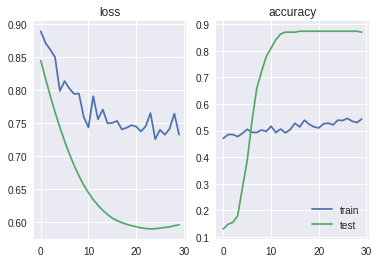

In [105]:
f1,Rec,Spec,auprc,auroc,fpr,tpr=model_eval(Xft_valid,yft_valid)

## Tremor


In [30]:
X = np.load('Trainclips.npy')
y = scores_tremor.values
task = le.fit_transform(data.Task)
visit = le.fit_transform(data.Visit)
subj = le.fit_transform(data.Subject)
print(X.shape)
print(y.shape)

(27546, 313, 6)
(27546,)


In [31]:
#remove rows (tasks) for which bradykinesia scores do not exists
indok = np.where(~np.isnan(y))[0]
X = X[indok,:,:]
y = y[indok]
task = task[indok]
visit = visit[indok]
subj = subj[indok]

In [32]:
np.std(y)

0.6294887086055725

In [97]:
np.unique(task)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [98]:
print(X.shape)
print(y.shape)
print(task.shape)
print(visit.shape)
print(subj.shape)

(27273, 313, 6)
(27273,)
(27273,)
(27273,)
(27273,)


In [33]:
#binarize labels
y[y>0] = 1

reshaping data for different models ...
CNN
X_train = 
(23063, 1, 313, 6)
model training ... - eval on visit [0]
f1_test=0.582, Prec=0.866, Rec=0.439, Spec=0.961, auprc=0.760, auroc=0.816
[[2567  104]
 [ 864  675]]
reshaping data for different models ...
CNN
X_train = 
(23417, 1, 313, 6)
model training ... - eval on visit [1]
f1_test=0.666, Prec=0.684, Rec=0.649, Spec=0.934, auprc=0.742, auroc=0.904
[[2955  208]
 [ 243  450]]
reshaping data for different models ...
CNN
X_train = 
(23442, 1, 313, 6)
model training ... - eval on visit [2]
f1_test=0.691, Prec=0.648, Rec=0.742, Spec=0.919, auprc=0.751, auroc=0.929
[[2934  258]
 [ 165  474]]
reshaping data for different models ...
CNN
X_train = 
(23376, 1, 313, 6)
model training ... - eval on visit [3]
f1_test=0.579, Prec=0.785, Rec=0.459, Spec=0.956, auprc=0.711, auroc=0.859
[[2770  126]
 [ 542  459]]
reshaping data for different models ...
CNN
X_train = 
(23458, 1, 313, 6)
model training ... - eval on visit [4]
f1_test=0.650, Prec=0.810, 

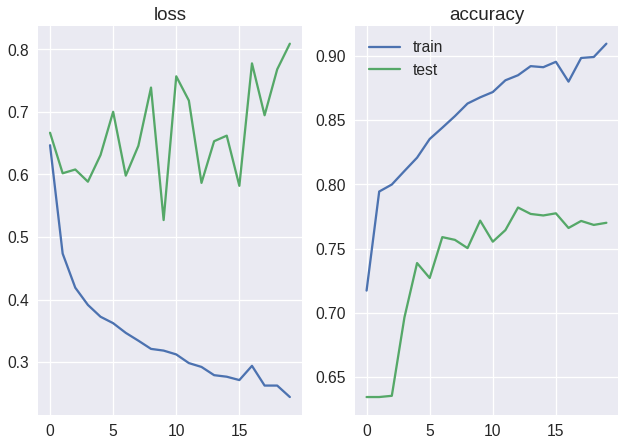

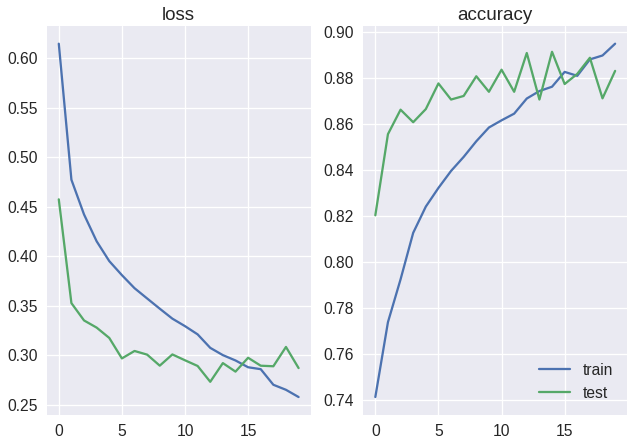

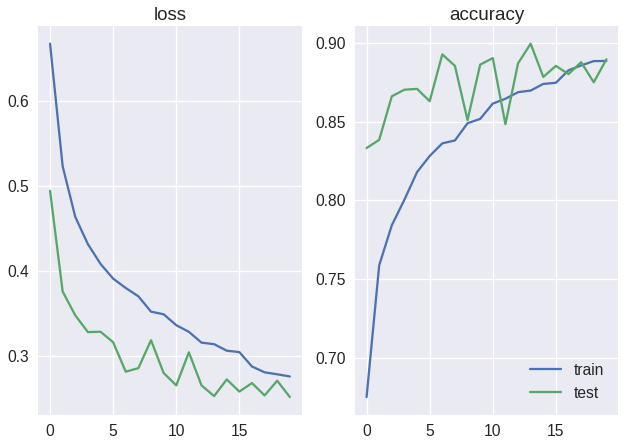

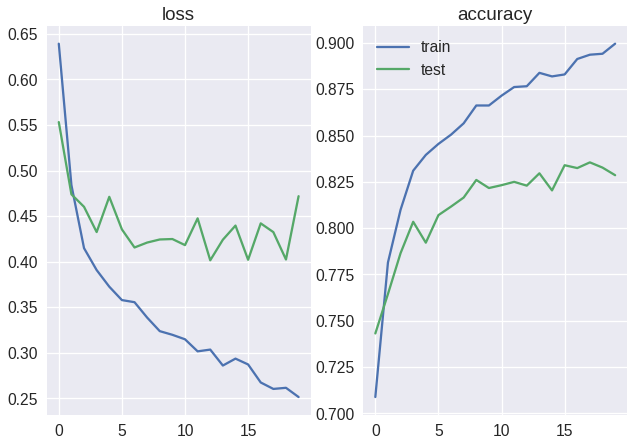

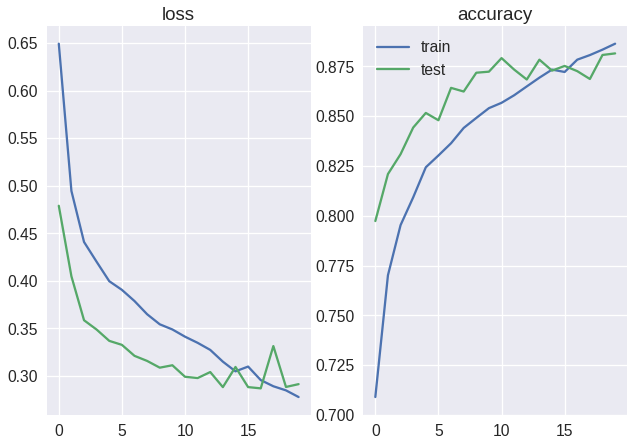

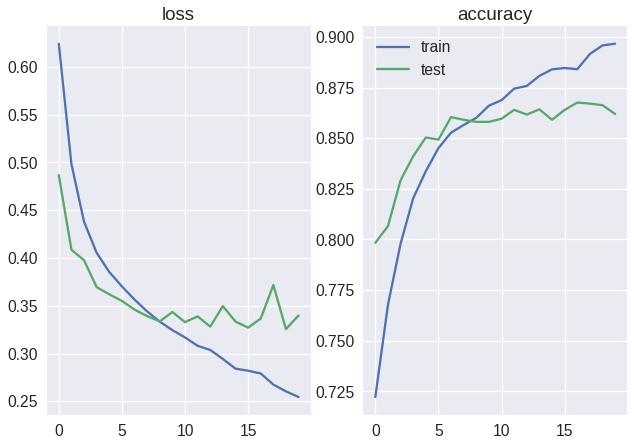

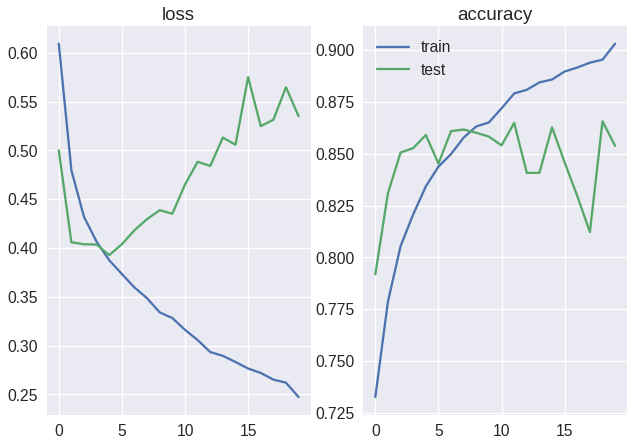

In [100]:
#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16
num_classes = 2 # 
rec_task = pd.DataFrame()

#split by subject and loop 
loso = LeaveOneGroupOut()
f1all=[]; auprcall=[]; aurocall=[]; rec_all=[]; spec_all=[]
for train_index, test_index in loso.split(X, y, visit):
    
    RecS=[] #store recall per task
    
    current_visit = np.unique(visit[test_index])
    task_subj = task[test_index] #tasks for current visit

    X_train = X[train_index]; y_train = y[train_index]
    X_valid = X[test_index]; y_valid = y[test_index]  

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)

    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type='CNN')
    print('X_train = ')
    #swap axes to have channel as last dim
    X_train = np.swapaxes(X_train,1,3)
    X_valid = np.swapaxes(X_valid,1,3)
    print(X_train.shape)

    #model
    model=buildCNN(win_len,dim)
    print('model training ... - eval on visit %s'%current_visit)
    epochs = 20
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
    hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid),verbose=0)
    f1,Rec,Spec,auprc,auroc=model_eval(X_valid,y_valid)
    f1all.append(f1)
    auprcall.append(auprc)
    aurocall.append(auroc)
    rec_all.append(Rec)
    spec_all.append(Spec)
    
    #store recall per task
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    y_valid = np.argmax(y_valid,axis=1)
    for t in np.unique(task_subj):
        
        ind_task = task_subj==t
        ypred_s = y_pred[ind_task]
        ytrue_s = y_valid[ind_task]
        TP=sum(ypred_s[ytrue_s==1])
        P = sum(ytrue_s == 1)
        RecS.append(TP/P)
        
    rec_task[current_visit[0]]=np.asarray(RecS)


        

In [51]:
#save current model weights
model.save('./Models/model_tremor_LOVO.h5')

In [101]:
Results = {'f1':f1all, 'recall':rec_all, 'spec':spec_all, 'auroc':aurocall, 'auprc':auprcall, 'rec_task':rec_task}
np.save('./Results/Tremor_results.npy',Results)

In [34]:
Results=np.load('./Results/Tremor_results.npy')
rec_task = Results.item()['rec_task']

In [35]:
print(np.mean(Results.item()['recall']),np.std(Results.item()['recall']))

0.5928644196075092 0.10608595712210471


In [36]:
print(np.mean(Results.item()['spec']),np.std(Results.item()['spec']))

0.9366345598842108 0.023484903557563386


In [37]:
print(np.mean(Results.item()['auroc']),np.std(Results.item()['auroc']))

0.876448770271889 0.040830318954939236


/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


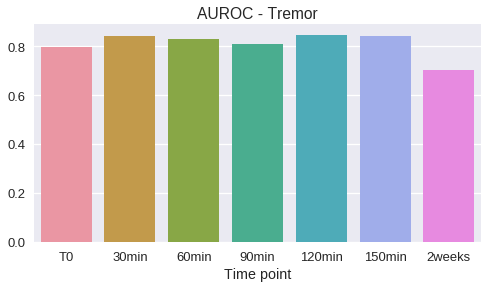

In [52]:
plt.figure(figsize=(8,4))
sns.set_context('talk')
ax=sns.barplot(x=np.arange(len(np.unique(visit))),y=aurocall)
plt.title('AUROC - Tremor')
plt.xlabel('Time point')
ax=plt.xticks(np.arange(7),['T0','30min','60min','90min','120min','150min','2weeks'])

In [54]:
rec_task

0         1         2         3  \
Motor #10: Drinking Water             0.336735  0.445946  0.703125  0.266129   
Motor #11: Organizing Folder          0.282258  0.492754  0.455556  0.463768   
Motor #12: Folding Towels             0.444444  0.686957  0.551724  0.517857   
Motor #2: Walking                     0.581818  0.692308  0.615385  0.923077   
Motor #3: Walking while Counting      0.688889  0.733333  0.769231  0.592593   
Motor #4: Finger to Nose              0.619048  0.820513  0.867647  0.546392   
Motor #5: Alternating Hand Movements  0.520000  0.653333  0.959459  0.648649   
Motor #6: Sit to Stand                0.400000       NaN  0.333333  0.187500   
Motor #7: Drawing on Paper            0.584906  0.613636  0.595238  0.094340   
Motor #8: Typing on a Computer        0.421053  0.701754  0.954545  0.391753   
Motor #9: Nuts and Bolts              0.408284  0.698413  0.823529  0.433333   

                                             4         5         6  
Motor #10: Drinking Water             0.253012  0.351648  0.591837  
Motor #11: Organizing Folder          0.301724  0.468750  0.615385  
Motor #12: Folding Towels             0.517241  0.750000  0.793750  
Motor #2: Walking                     0.750000  0.714286  0.080000  
Motor #3: Walking while Counting      0.631579  0.705882  0.000000  
Motor #4: Finger to Nose              0.793651  0.753247  0.593023  
Motor #5: Alternating Hand Movements  0.841667  0.818841  0.691489  
Motor #6: Sit to Stand                     NaN       NaN       NaN  
Motor #7: Drawing on Paper            0.607143  0.743590  0.787879  
Motor #8: Typing on a Computer        0.482353  0.540230  0.734940  
Motor #9: Nuts and Bolts              0.554217  0.776119  0.858974

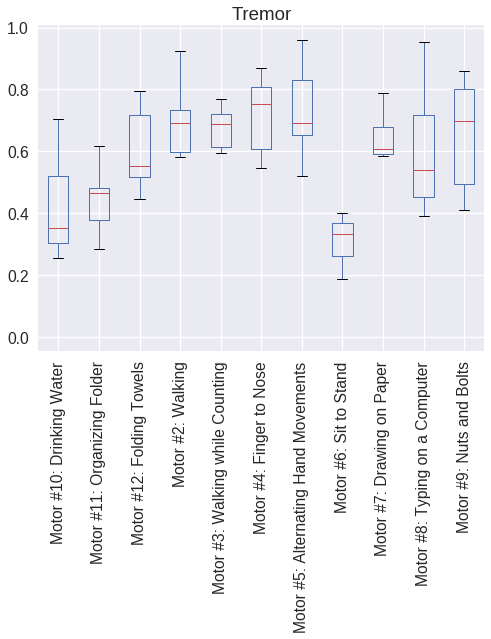

In [76]:
sns.set_context('talk',font_scale=1.2)
plt.figure(figsize=(8,6))
rec_task.index = tasknames
rec_task.T.boxplot()
ax=plt.xticks(rotation=90)
plt.title('Tremor')

In [55]:
from scipy.stats import ranksums

In [69]:
x = rec_task.iloc[3,:]
y = rec_task.iloc[5,:]

In [75]:
for i in range(len(rec_task)):
    print(rec_task.index[i],np.median(rec_task.iloc[i,:]))
    x = rec_task.iloc[i,:]
    print(ranksums(x,y))

Motor #10: Drinking Water 0.3516483516483517
RanksumsResult(statistic=-2.6193939164997535, pvalue=0.00880861651937405)
Motor #11: Organizing Folder 0.463768115942029
RanksumsResult(statistic=-2.8749445424997293, pvalue=0.004040984683985582)
Motor #12: Folding Towels 0.5517241379310345
RanksumsResult(statistic=-1.5971914124998496, pvalue=0.11022304635486535)
Motor #2: Walking 0.6923076923076923
RanksumsResult(statistic=-0.7027642214999339, pvalue=0.48220269762779056)
Motor #3: Walking while Counting 0.6888888888888889
RanksumsResult(statistic=-0.9583148474999098, pvalue=0.33790401910300505)
Motor #4: Finger to Nose 0.7532467532467533
RanksumsResult(statistic=0.0, pvalue=1.0)
Motor #5: Alternating Hand Movements 0.6914893617021277
RanksumsResult(statistic=0.3194382824999699, pvalue=0.7493941849625707)
Motor #6: Sit to Stand nan
RanksumsResult(statistic=0.4472135954999579, pvalue=0.6547208460185769)
Motor #7: Drawing on Paper 0.6071428571428571
RanksumsResult(statistic=-1.3416407864998738

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [32]:
rec_task.T.median()

Motor #10: Drinking Water               0.351648
Motor #11: Organizing Folder            0.463768
Motor #12: Folding Towels               0.551724
Motor #2: Walking                       0.692308
Motor #3: Walking while Counting        0.688889
Motor #4: Finger to Nose                0.753247
Motor #5: Alternating Hand Movements    0.691489
Motor #6: Sit to Stand                  0.333333
Motor #7: Drawing on Paper              0.607143
Motor #8: Typing on a Computer          0.540230
Motor #9: Nuts and Bolts                0.698413
dtype: float64

In [111]:
print(list(zip(taskcodes,tasknames)))

[(0, 'Motor #10: Drinking Water'), (1, 'Motor #11: Organizing Folder'), (2, 'Motor #12: Folding Towels'), (3, 'Motor #2: Walking'), (4, 'Motor #3: Walking while Counting'), (5, 'Motor #4: Finger to Nose'), (6, 'Motor #5: Alternating Hand Movements'), (7, 'Motor #6: Sit to Stand'), (8, 'Motor #7: Drawing on Paper'), (9, 'Motor #8: Typing on a Computer'), (10, 'Motor #9: Nuts and Bolts')]


Include personal data

reshaping data for different models ...
CNN
X_train = 
(24753, 1, 313, 6)
model training ... - eval on subj [0]
f1_test=0.384, Prec=0.307, Rec=0.510, Spec=0.646, auprc=0.386, auroc=0.586
[[714 392]
 [167 174]]
reshaping data for different models ...
CNN
X_train = 
(24541, 1, 313, 6)
model training ... - eval on subj [1]
f1_test=0.807, Prec=0.950, Rec=0.701, Spec=0.647, auprc=0.923, auroc=0.654
[[ 101   55]
 [ 449 1054]]
reshaping data for different models ...
CNN
X_train = 
(24678, 1, 313, 6)
model training ... - eval on subj [2]
f1_test=0.678, Prec=0.716, Rec=0.643, Spec=0.676, auprc=0.773, auroc=0.708
[[453 217]
 [304 548]]
reshaping data for different models ...
CNN
X_train = 
(24614, 1, 313, 6)
model training ... - eval on subj [3]
f1_test=0.621, Prec=0.463, Rec=0.942, Spec=0.594, auprc=0.757, auroc=0.885
[[687 469]
 [ 25 405]]
reshaping data for different models ...
CNN
X_train = 
(24683, 1, 313, 6)
model training ... - eval on subj [4]
f1_test=0.541, Prec=0.666, Rec=0.456, Spec=0

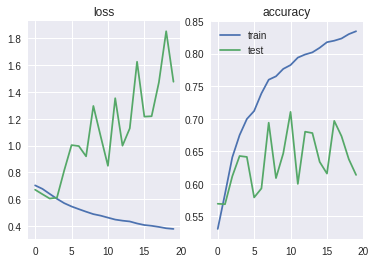

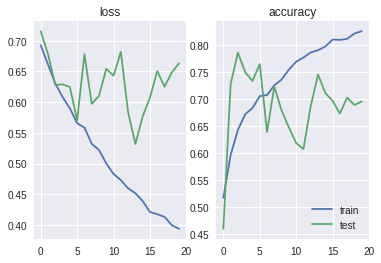

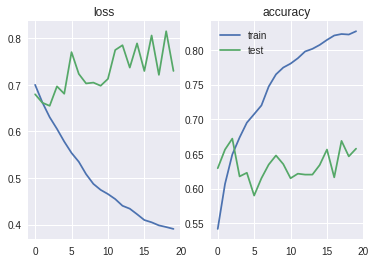

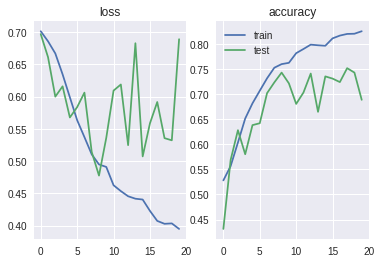

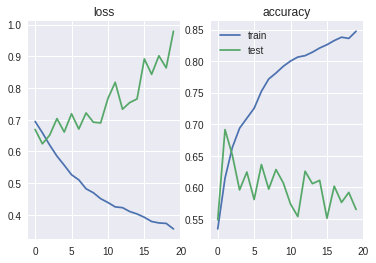

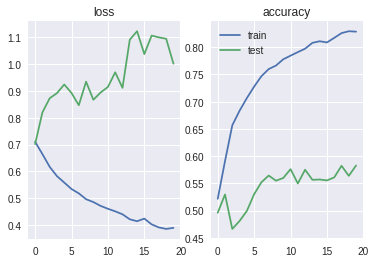

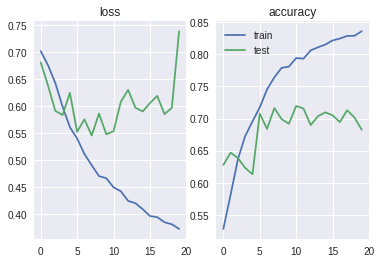

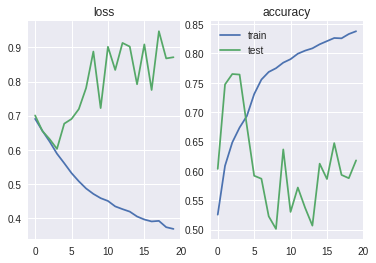

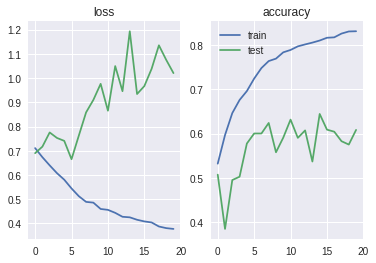

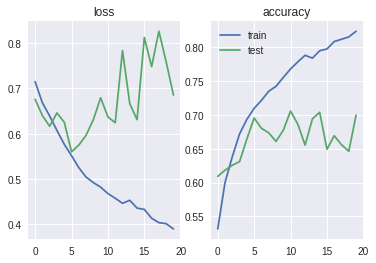

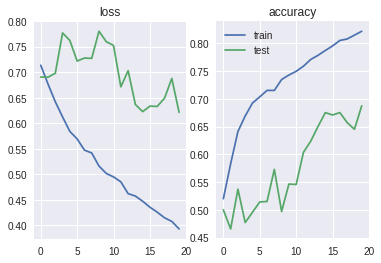

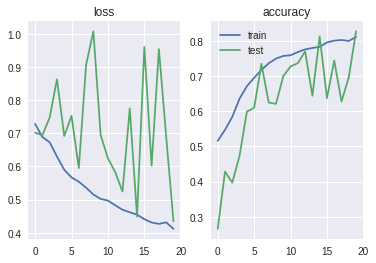

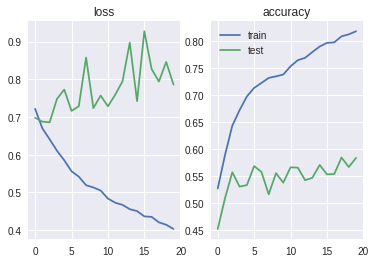

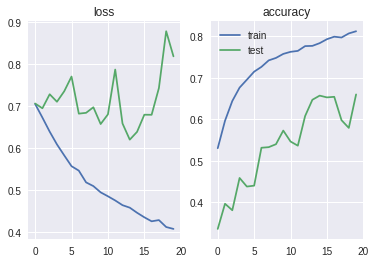

In [127]:
#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16
num_classes = 2 # 
rec_task = pd.DataFrame()

#split by subject and loop 
loso = LeaveOneGroupOut()
f1all=[]; auprcall=[]; aurocall=[]
for train_index, test_index in loso.split(X, y, subj):
    
    RecS=[] #store recall per task
    
    current_subj = np.unique(subj[test_index])
    task_subj = task[test_index] #tasks for current subj
    visit_subj = visit[test_index] #visits for current subj

    X_train = X[train_index]; y_train = y[train_index]
    X_valid = X[test_index]; y_valid = y[test_index]  
    
    #include data from current patient visit 0 in training
    X_train=np.concatenate((X_train,X_valid[visit_subj==0]),axis=0)
    y_train=np.concatenate((y_train,y_valid[visit_subj==0]))
    X_valid=X_valid[visit_subj!=0]
    y_valid=y_valid[visit_subj!=0]

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)

    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type='CNN')
    print('X_train = ')
    #swap axes to have channel as last dim
    X_train = np.swapaxes(X_train,1,3)
    X_valid = np.swapaxes(X_valid,1,3)
    print(X_train.shape)

    #model
    model=buildCNN(win_len,dim)
    print('model training ... - eval on subj %s'%current_subj)
    epochs = 20
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
    hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid),verbose=0)
    f1,Rec,Spec,auprc,auroc=model_eval(X_valid,y_valid)
    f1all.append(f1)
    auprcall.append(auprc)
    aurocall.append(auroc)

        

In [128]:
#save current model weights
model.save('./Models/modelpers_brady.h5')

0.6958418591583018 0.05007712006393535


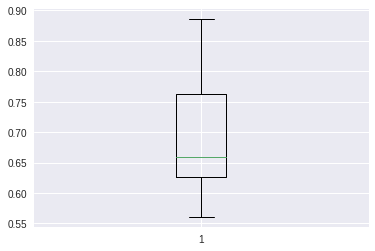

In [139]:
ax=plt.boxplot(aurocall)
print(np.mean(aurocall),1.96*np.std(aurocall)/np.sqrt(len(aurocall)))

0.635239094052561 0.11645612118108234


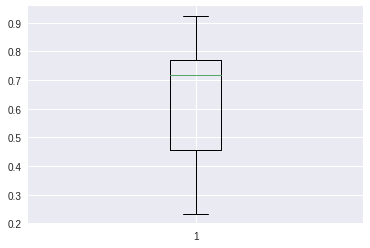

In [140]:
ax=plt.boxplot(auprcall)
print(np.mean(auprcall),1.96*np.std(auprcall)/np.sqrt(len(auprcall)))

Batch norm does not improve results nor stabilize performance on valid set

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


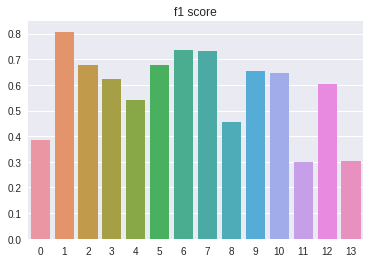

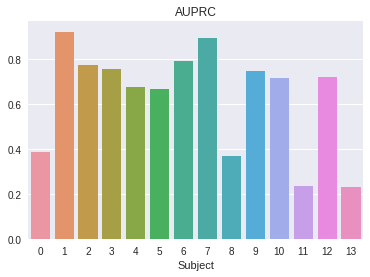

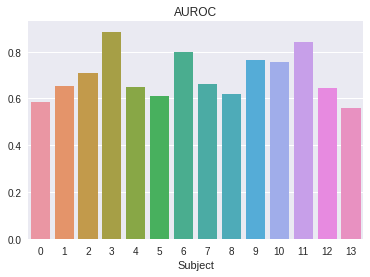

In [129]:
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=f1all)
plt.title('f1 score')
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=auprcall)
plt.title('AUPRC')
plt.xlabel('Subject')
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
plt.title('AUROC')
plt.xlabel('Subject')

(-0.22730238141766096, 0.43450423609134803)


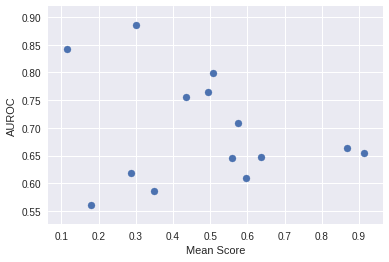

In [131]:
plt.scatter(x=P_ratio,y=aurocall)
print(pearsonr(P_ratio,aurocall))
plt.xlabel('Mean Score')
plt.ylabel('AUROC')

### Use k-fold CV

In [43]:
#load clips, standardize and split data into train and valid set
def prepare_data(X,y,network_type,balance=False):
    
    #standardize all data (note - should std training and apply on test)
#     Xn = stdclipdata(X)
#     Xn = X
    
    #perform a random train_valid split first to test approach
    inds = np.arange(0,len(y))
    X_train,X_valid,y_train,y_valid,inds_train,inds_valid = train_test_split(X,y,inds,test_size=0.2,stratify=task,random_state=32)
    print('X_train = ')
    print(X_train.shape)
    print('X_valid = ')
    print(X_valid.shape)
    
    #balance training dataset
    if balance:
        indsp = np.where(y_train==1)[0]
        indsn = np.random.choice(np.where(y_train==0)[0],size=round(1.5*len(indsp)),replace=False)
        inds = np.hstack((indsp,indsn))
        X_train=X_train[inds]
        y_train=y_train[inds]

    num_classes = 2 # 
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)
    
    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type)
    print('X_train = ')
    print(X_train.shape)

    return X_train,y_train,X_valid,y_valid,inds_train,inds_valid,win_len,dim

In [44]:
X_train,y_train,X_valid,y_valid,inds_train,inds_valid,win_len,dim = prepare_data(X,y,'CNN')

X_train = 
(21159, 313, 6)
X_valid = 
(5290, 313, 6)
reshaping data for different models ...
CNN
X_train = 
(21159, 6, 313, 1)


In [45]:
#swap axes to have channel as last dim
X_train = np.swapaxes(X_train,1,3)
X_valid = np.swapaxes(X_valid,1,3)
print(X_train.shape)

(21159, 1, 313, 6)


In [46]:
#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16
num_classes =2 

In [47]:
print('building the model ...')
model=Sequential()
model.add(Conv2D(filters=16, kernel_size=(1, 32),activation='relu',input_shape=(1, win_len, dim),padding='same'))
model.add(MaxPooling2D(pool_size=(1, 4)))
model.add(Conv2D(filters=16, kernel_size=(1, 16), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(1, 6)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

building the model ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 313, 16)        3088      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 78, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 78, 16)         4112      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 13, 16)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 208)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                6688      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)              

In [48]:
print('model training ...')
epochs = 40
model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid))

model training ...
Train on 21159 samples, validate on 5290 samples
Epoch 1/40
21159/21159 [==============================] - 1s - loss: 0.6966 - acc: 0.5287 - val_loss: 0.6810 - val_acc: 0.5828
Epoch 2/40
21159/21159 [==============================] - 1s - loss: 0.6717 - acc: 0.5852 - val_loss: 0.6523 - val_acc: 0.6251
Epoch 3/40
21159/21159 [==============================] - 1s - loss: 0.6455 - acc: 0.6328 - val_loss: 0.6200 - val_acc: 0.6599
Epoch 4/40
21159/21159 [==============================] - 1s - loss: 0.6191 - acc: 0.6585 - val_loss: 0.5916 - val_acc: 0.6764
Epoch 5/40
21159/21159 [==============================] - 1s - loss: 0.5909 - acc: 0.6823 - val_loss: 0.5557 - val_acc: 0.7057
Epoch 6/40
21159/21159 [==============================] - 1s - loss: 0.5629 - acc: 0.7105 - val_loss: 0.5274 - val_acc: 0.7418
Epoch 7/40
21159/21159 [==============================] - 1s - loss: 0.5408 - acc: 0.7368 - val_loss: 0.5240 - val_acc: 0.7437
Epoch 8/40
21159/21159 [===================

Unfitered

f1_test=0.811, Prec=0.784, Rec=0.839, auprc=0.900
[[1967  624]
 [ 434 2265]]
the mean f1 score:0.80


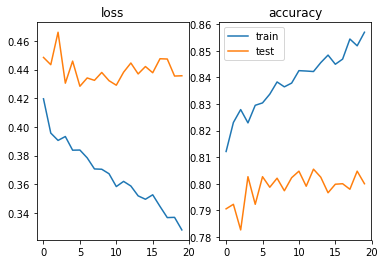

In [127]:
model_eval(X_valid,y_valid)

HP filtered data

f1_test=0.819, Prec=0.815, Rec=0.823, auprc=0.905
[[2087  504]
 [ 478 2221]]
the mean f1 score:0.82


(0.8189528023598821, 0.9045758795206189)

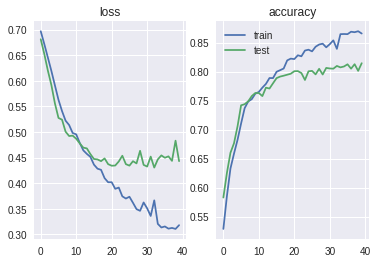

In [49]:
model_eval(X_valid,y_valid)

In [107]:
np.unique(task)

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10])

In [108]:
rec_task.shape

(10, 14)

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


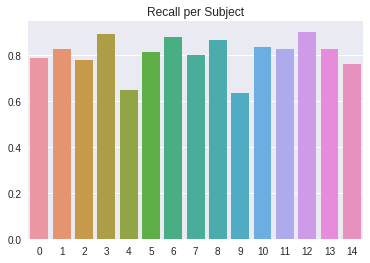

In [50]:
#recall rate per subject
y_pred = np.argmax(model.predict(X_valid),axis=1)
y_valid = np.argmax(y_valid,axis=1)
subj_valid=subj[inds_valid]

RecS = []
for s in np.unique(subj_valid):

    indS = np.where(subj_valid==s)
    ytrue_s = y_valid[indS]
    ypred_s = y_pred[indS]
    TP=sum(ypred_s[ytrue_s==1])
    P = sum(ytrue_s == 1)
    RecS.append(TP/P)
    
ax = sns.barplot(x=np.arange(len(RecS)),y=RecS)
plt.title('Recall per Subject')

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

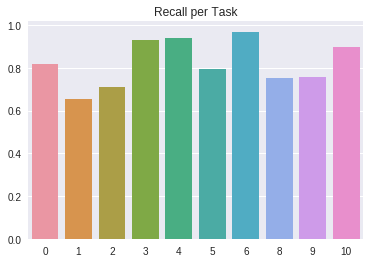

In [51]:
#recall rate per task
y_pred = np.argmax(model.predict(X_valid),axis=1)
# y_valid = np.argmax(y_valid,axis=1)
task_valid=task[inds_valid]

RecS = []
for s in np.unique(task_valid):

    indS = np.where(task_valid==s)
    ytrue_s = y_valid[indS]
    ypred_s = y_pred[indS]
    TP=sum(ypred_s[ytrue_s==1])
    P = sum(ytrue_s == 1)
    RecS.append(TP/P)
    
ax = sns.barplot(x=np.unique(task_valid),y=RecS)
plt.title('Recall per Task')
plt.xticks()

In [52]:
le = LabelEncoder()
taskcodes = le.fit_transform(data.Task)
taskcodes = np.unique(taskcodes)
tasknames = le.inverse_transform(taskcodes)

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [53]:
print(list(zip(taskcodes,tasknames)))

[(0, 'Motor #10: Drinking Water'), (1, 'Motor #11: Organizing Folder'), (2, 'Motor #12: Folding Towels'), (3, 'Motor #2: Walking'), (4, 'Motor #3: Walking while Counting'), (5, 'Motor #4: Finger to Nose'), (6, 'Motor #5: Alternating Hand Movements'), (7, 'Motor #6: Sit to Stand'), (8, 'Motor #7: Drawing on Paper'), (9, 'Motor #8: Typing on a Computer'), (10, 'Motor #9: Nuts and Bolts')]


In [54]:
indscorrect=inds_valid[y_valid==y_pred]
indswrong=inds_valid[y_valid!=y_pred]

In [55]:
len(indswrong)

982

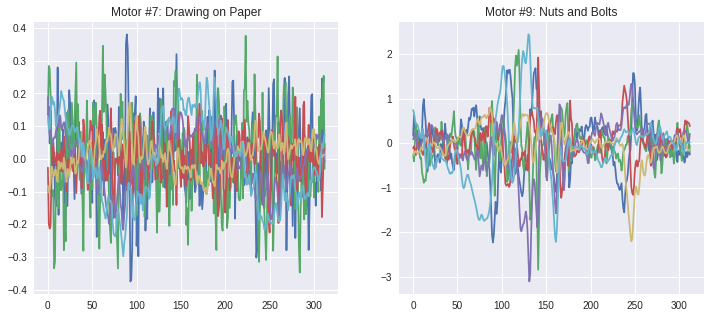

In [56]:
tasklist=(list(zip(taskcodes,tasknames)))
idx1 = np.random.choice(indswrong,size=1)
idx2 = np.random.choice(indscorrect,size=1)
fig=plt.figure(figsize=(12,5))
fig.add_subplot(121)
plt.plot(X[idx1][0])
plt.title(tasklist[int(task[idx1])][1])
fig.add_subplot(122)
plt.plot(X[idx2][0])
plt.title(tasklist[int(task[idx2])][1])

## Train on Tremor

In [101]:
X = np.concatenate((accn,gyrn),axis=-1) #use acc and gyro data
y = scores_tremor.values
print(X.shape)
print(y.shape)

(27805, 313, 6)
(27805,)


In [103]:
#remove rows (tasks) for which bradykinesia scores do not exists
indok = ~np.isnan(y)
X = X[indok,:,:]
y = y[indok]
task = task[indok]
visit = visit[indok]
subj = subj[indok]

In [104]:
np.unique(task)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [105]:
print(X.shape)
print(y.shape)
print(task.shape)
print(visit.shape)
print(subj.shape)

(27532, 313, 6)
(27532,)
(27532,)
(27532,)
(27532,)


In [106]:
#binarize labels
y[y>0] = 1

In [107]:
sum(y>0)/len(y)

0.22784396338805754

LOSO CV

reshaping data for different models ...
CNN
X_train = 
(25738, 1, 313, 6)
model training ... - eval on subj [0]
f1_test=0.404, Prec=0.348, Rec=0.481, auprc=0.439
[[1387  193]
 [ 111  103]]
the mean f1 score:0.65
reshaping data for different models ...
CNN
X_train = 
(25490, 1, 313, 6)
model training ... - eval on subj [1]
f1_test=0.377, Prec=0.761, Rec=0.250, auprc=0.673
[[904  83]
 [791 264]]
the mean f1 score:0.53
reshaping data for different models ...
CNN
X_train = 
(25693, 1, 313, 6)
model training ... - eval on subj [2]
f1_test=0.571, Prec=0.700, Rec=0.483, auprc=0.583
[[1559   48]
 [ 120  112]]
the mean f1 score:0.76
reshaping data for different models ...
CNN
X_train = 
(25590, 1, 313, 6)
model training ... - eval on subj [3]
f1_test=0.506, Prec=0.448, Rec=0.583, auprc=0.489
[[1765   74]
 [  43   60]]
the mean f1 score:0.74
reshaping data for different models ...
CNN
X_train = 
(27286, 1, 313, 6)
model training ... - eval on subj [4]
f1_test=0.566, Prec=0.582, Rec=0.552, auprc=

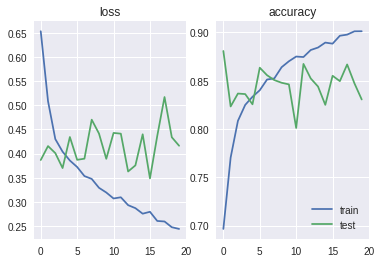

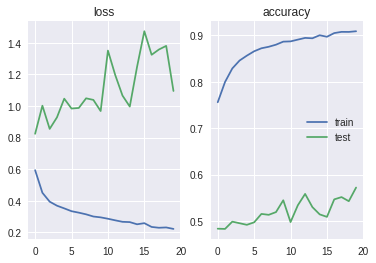

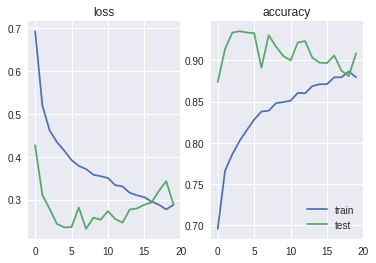

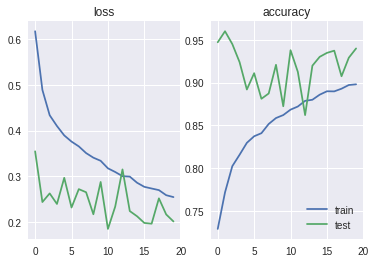

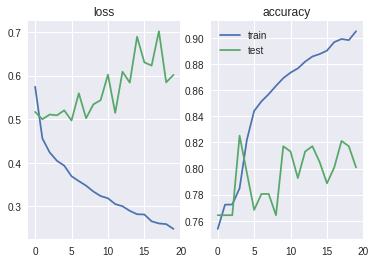

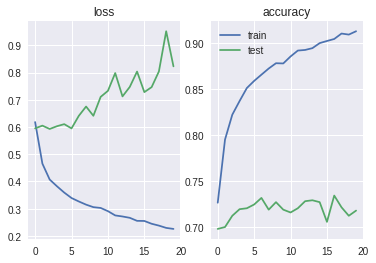

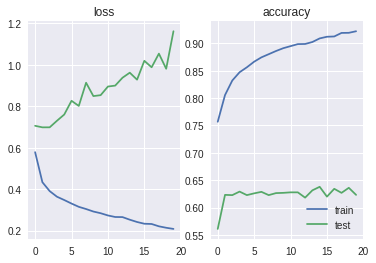

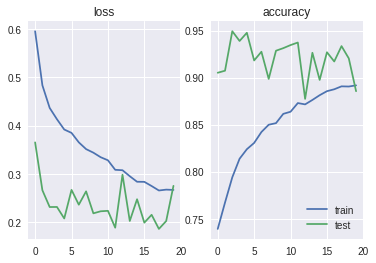

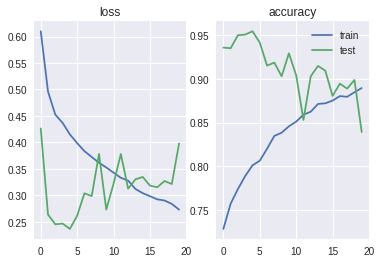

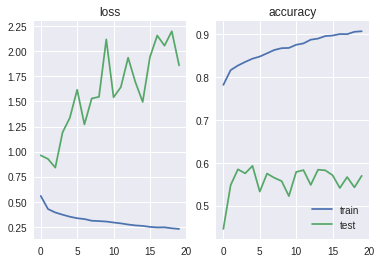

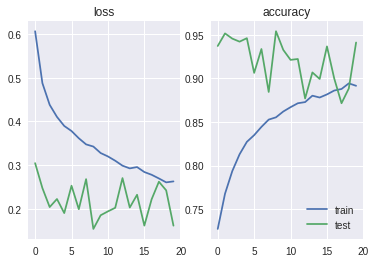

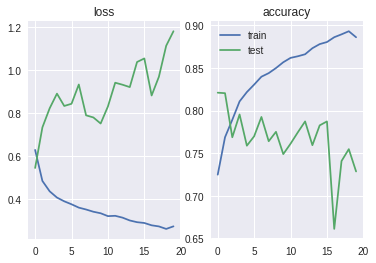

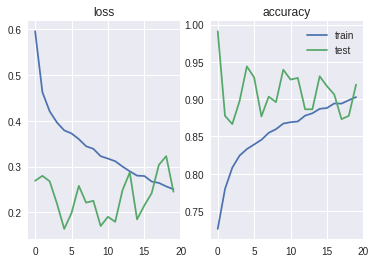

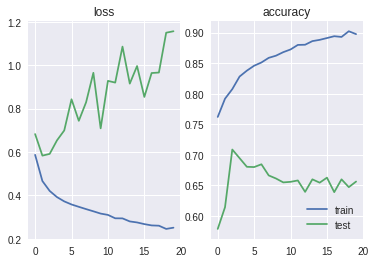

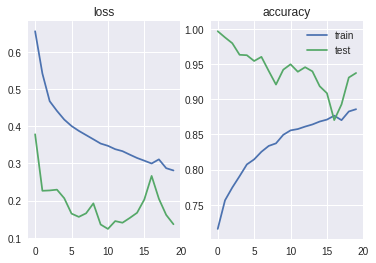

In [125]:
#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16
num_classes = 2 # 

#split by subject and loop 
loso = LeaveOneGroupOut()
f1all=[]; auprcall=[]
for train_index, test_index in loso.split(X, y, subj):
    current_subj = np.unique(subj[test_index])
    X_train = X[train_index]; y_train = y[train_index]
    X_valid = X[test_index]; y_valid = y[test_index]  

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)

    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type='CNN')
    print('X_train = ')
    #swap axes to have channel as last dim
    X_train = np.swapaxes(X_train,1,3)
    X_valid = np.swapaxes(X_valid,1,3)
    print(X_train.shape)

    #model
    model=buildCNN(win_len,dim)
    print('model training ... - eval on subj %s'%current_subj)
    epochs = 20
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
    hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid),verbose=0)
    f1,auprc=model_eval(X_valid,y_valid)
    f1all.append(f1)
    auprcall.append(auprc)

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


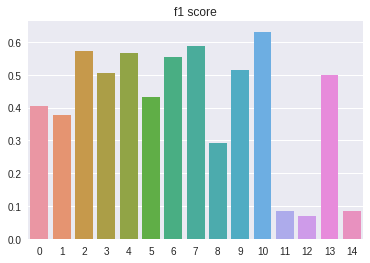

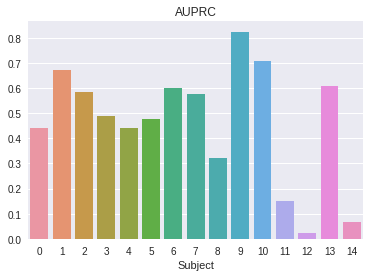

In [126]:
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=f1all)
plt.title('f1 score')
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=auprcall)
plt.title('AUPRC')
plt.xlabel('Subject')

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


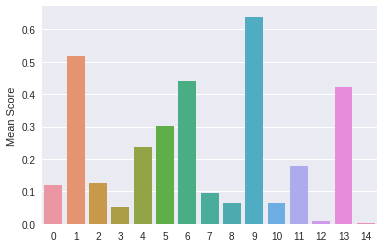

In [127]:
P_ratio=[];meanscore=[]
for train_index, test_index in loso.split(X, y, subj):
    P_ratio.append(sum(y[test_index]==1)/len(y[test_index]))        
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=P_ratio)
plt.ylabel('Mean Score')

from scipy.stats import pearsonr

(0.6392925095102815, 0.010287380629063161)

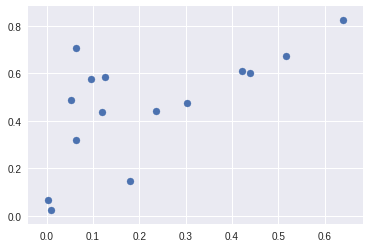

In [128]:
plt.scatter(x=P_ratio,y=auprcall)
pearsonr(P_ratio,auprcall)    

In [108]:
#load clips, standardize and split data into train and valid set
def prepare_data(X,y,network_type,balance=False):
    
    #standardize all data (note - should std training and apply on test)
#     Xn = stdclipdata(X)
#     Xn = X
    
    #perform a random train_valid split first to test approach
    inds = np.arange(0,len(y))
    X_train,X_valid,y_train,y_valid,inds_train,inds_valid = train_test_split(X,y,inds,test_size=0.2,stratify=task,random_state=32)
    print('X_train = ')
    print(X_train.shape)
    print('X_valid = ')
    print(X_valid.shape)
    
    #balance training dataset
    if balance:
        indsp = np.where(y_train==1)[0]
        indsn = np.random.choice(np.where(y_train==0)[0],size=round(1.5*len(indsp)),replace=False)
        inds = np.hstack((indsp,indsn))
        X_train=X_train[inds]
        y_train=y_train[inds]

    num_classes = 2 # 
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)
    
    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type)
    print('X_train = ')
    print(X_train.shape)

    return X_train,y_train,X_valid,y_valid,inds_train,inds_valid,win_len,dim

In [109]:
X_train,y_train,X_valid,y_valid,inds_train,inds_valid,win_len,dim = prepare_data(X,y,'CNN')

X_train = 
(22025, 313, 6)
X_valid = 
(5507, 313, 6)
reshaping data for different models ...
CNN
X_train = 
(22025, 6, 313, 1)


In [110]:
#swap axes to have channel as last dim
X_train = np.swapaxes(X_train,1,3)
X_valid = np.swapaxes(X_valid,1,3)
print(X_train.shape)

(22025, 1, 313, 6)


In [111]:
#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16
num_classes =2 

In [112]:
print('building the model ...')
model=Sequential()
model.add(Conv2D(filters=16, kernel_size=(1, 32),activation='relu',input_shape=(1, win_len, dim),padding='same'))
model.add(MaxPooling2D(pool_size=(1, 4)))
model.add(Conv2D(filters=16, kernel_size=(1, 16), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(1, 6)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

building the model ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 1, 313, 16)        3088      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 1, 78, 16)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 1, 78, 16)         4112      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 1, 13, 16)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 208)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 32)                6688      
_________________________________________________________________
dropout_31 (Dropout)         (None, 32)              

In [113]:
print('model training ...')
epochs = 20
model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid))

model training ...
Train on 22025 samples, validate on 5507 samples
Epoch 1/20
22025/22025 [==============================] - 1s - loss: 0.6047 - acc: 0.7501 - val_loss: 0.5125 - val_acc: 0.7705
Epoch 2/20
22025/22025 [==============================] - 1s - loss: 0.4939 - acc: 0.7753 - val_loss: 0.4315 - val_acc: 0.7817
Epoch 3/20
22025/22025 [==============================] - 1s - loss: 0.4403 - acc: 0.7889 - val_loss: 0.4152 - val_acc: 0.8133
Epoch 4/20
22025/22025 [==============================] - 1s - loss: 0.4274 - acc: 0.8028 - val_loss: 0.3961 - val_acc: 0.8217
Epoch 5/20
22025/22025 [==============================] - 1s - loss: 0.4054 - acc: 0.8146 - val_loss: 0.4084 - val_acc: 0.8153
Epoch 6/20
22025/22025 [==============================] - 1s - loss: 0.4017 - acc: 0.8198 - val_loss: 0.3773 - val_acc: 0.8319
Epoch 7/20
22025/22025 [==============================] - 1s - loss: 0.3804 - acc: 0.8319 - val_loss: 0.3795 - val_acc: 0.8315
Epoch 8/20
22025/22025 [===================

f1_test=0.607, Prec=0.838, Rec=0.475, auprc=0.769
[[4127  116]
 [ 663  601]]
the mean f1 score:0.76


(0.6067642604745078, 0.7687360236982189)

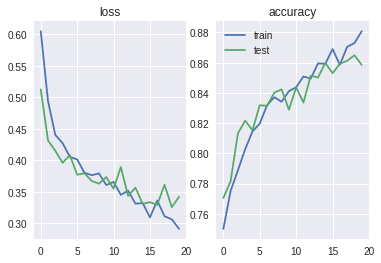

In [114]:
model_eval(X_valid,y_valid)

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


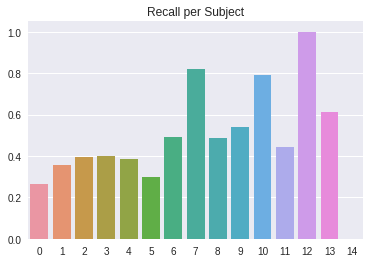

In [117]:
#recall rate per subject
y_pred = np.argmax(model.predict(X_valid),axis=1)
subj_valid=subj[inds_valid]

RecS = []
for s in np.unique(subj_valid):

    indS = np.where(subj_valid==s)
    ytrue_s = y_valid[indS]
    ypred_s = y_pred[indS]
    TP=sum(ypred_s[ytrue_s==1])
    P = sum(ytrue_s == 1)
    RecS.append(TP/P)
    
ax = sns.barplot(x=np.arange(len(RecS)),y=RecS)
plt.title('Recall per Subject')

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

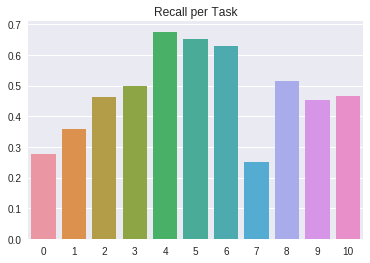

In [116]:
#recall rate per task
y_pred = np.argmax(model.predict(X_valid),axis=1)
y_valid = np.argmax(y_valid,axis=1)
task_valid=task[inds_valid]

RecS = []
for s in np.unique(task_valid):

    indS = np.where(task_valid==s)
    ytrue_s = y_valid[indS]
    ypred_s = y_pred[indS]
    TP=sum(ypred_s[ytrue_s==1])
    P = sum(ytrue_s == 1)
    RecS.append(TP/P)
    
ax = sns.barplot(x=np.unique(task_valid),y=RecS)
plt.title('Recall per Task')
plt.xticks()

In [123]:
le = LabelEncoder()
taskcodes = le.fit_transform(data.Task)
taskcodes = np.unique(taskcodes)
tasknames = le.inverse_transform(taskcodes)

/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [124]:
print(list(zip(taskcodes,tasknames)))

[(0, 'Motor #10: Drinking Water'), (1, 'Motor #11: Organizing Folder'), (2, 'Motor #12: Folding Towels'), (3, 'Motor #2: Walking'), (4, 'Motor #3: Walking while Counting'), (5, 'Motor #4: Finger to Nose'), (6, 'Motor #5: Alternating Hand Movements'), (7, 'Motor #6: Sit to Stand'), (8, 'Motor #7: Drawing on Paper'), (9, 'Motor #8: Typing on a Computer'), (10, 'Motor #9: Nuts and Bolts')]


/opt/anaconda/anaconda2/envs/py34/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


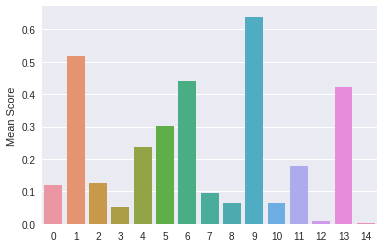

In [120]:
P_ratio=[];meanscore=[]
for train_index, test_index in loso.split(X, y, subj):
    P_ratio.append(sum(y[test_index]==1)/len(y[test_index]))        
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=P_ratio)
plt.ylabel('Mean Score')

from scipy.stats import pearsonr

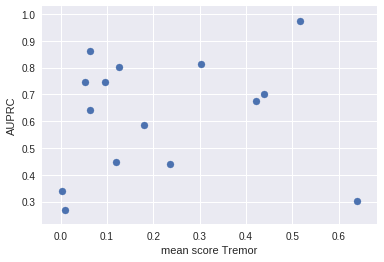

In [122]:
plt.scatter(x=P_ratio,y=auprcall)
pearsonr(P_ratio,auprcall)  
plt.xlabel('mean score Tremor')
plt.ylabel('AUPRC')

In [539]:
indscorrect=inds_valid[y_valid==y_pred]
indswrong=inds_valid[y_valid!=y_pred]

In [543]:
len(indswrong)

877

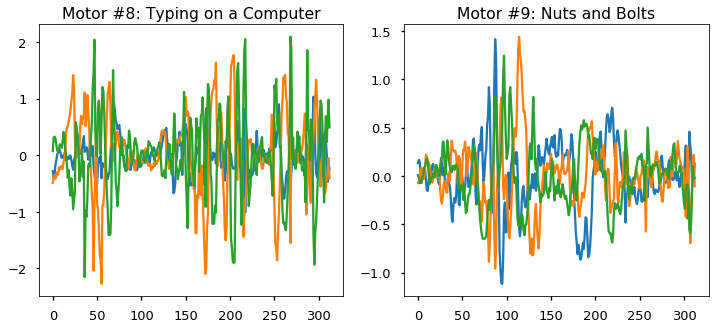

In [640]:
idx1 = np.random.choice(indswrong,size=1)
idx2 = np.random.choice(indscorrect,size=1)
fig=plt.figure(figsize=(12,5))
fig.add_subplot(121)
plt.plot(X[idx1][0])
plt.title(tasklist[int(task[idx1])][1])
fig.add_subplot(122)
plt.plot(X[idx2][0])
plt.title(tasklist[int(task[idx2])][1])

** One problem is that we do not know where the symptom shows in the entire recording**